# Modeling KMeans, KAgglomerativeClustering, Annoy

## Imports

In [ ]:
pip install --user annoy

In [ ]:
pip install seaborn

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
# from tqdm import tqdm
import pickle as pkl
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from annoy import AnnoyIndex
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans # import from sklearn
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average
from sklearn.metrics import silhouette_score, calinski_harabaz_score
from sklearn.decomposition import PCA
from sklearn import metrics
from mpl_toolkits.mplot3d import Axes3D

## Pickle Load and Helper Functions

In [2]:
df_for_brands = pkl.load(open('..\df_pickles\df_reg_1.p','rb'))

In [3]:
df_for_brands.drop('price',1,inplace=True)

In [4]:
df_for_brands_gas = df_for_brands[df_for_brands['Engine type']!='Electric']

In [5]:
df_for_brands_elec = df_for_brands[df_for_brands['Engine type']=='Electric']

In [6]:
prices = pkl.load(open('..\df_pickles\prices.p','rb'))

In [7]:
df_for_brands_gas = pd.concat([df_for_brands_gas, prices],1)

In [8]:
## GAS ##

In [9]:
df_gas = pkl.load(open('..\df_pickles\df_gas_sc_dmd.p','rb'))

In [10]:
df_gas_mod = df_gas.drop(['model', 'front_suspension_type_1',
       'front_suspension_type_2', 'front_suspension_type_3',
       'front_suspension_type_4', 'front_suspension_type_5',
       'front_suspension_type_6', 'front_suspension_type_7',
       'front_suspension_type_8', 'front_suspension_type_9', 
        'front_suspension_type_10', 'front_suspension_type_11',
       'front_suspension_type_12', 'front_wheel_diameter_15',
       'front_wheel_diameter_16', 'front_wheel_diameter_17',
       'front_wheel_diameter_18', 'front_wheel_diameter_19',
       'front_wheel_diameter_20', 'front_wheel_diameter_21',
       'front_wheel_diameter_22', 'rear_suspension_type_1',
       'rear_suspension_type_2', 'rear_suspension_type_3',
       'rear_suspension_type_4', 'rear_suspension_type_5', 
                          'rear_suspension_type_6',
       'rear_suspension_type_7', 'rear_suspension_type_8',
       'rear_suspension_type_9', 'rear_suspension_type_10',
       'rear_wheel_diameter_15', 'rear_wheel_diameter_16',
       'rear_wheel_diameter_17', 'rear_wheel_diameter_18',
       'rear_wheel_diameter_19', 'rear_wheel_diameter_20',
       'rear_wheel_diameter_21', 'rear_wheel_diameter_22',
                         'brand_1',
       'brand_2', 'brand_3', 'brand_4', 'brand_5', 'brand_6', 'brand_7',
       'brand_8', 'brand_9', 'brand_10', 'brand_11', 'brand_12', 'brand_13',
       'brand_14', 'brand_15', 'brand_16', 'brand_17', 'brand_18', 'brand_19',
       'brand_20', 'brand_21', 'brand_22', 'brand_23', 'brand_24', 'brand_25',
       'brand_26', 'brand_27', 'brand_28', 'brand_29', 'brand_30', 'brand_31',
       'brand_32', 'brand_33', 'brand_34', 'brand_35', 'brand_36', 'brand_37',
       'brand_39', 'brand_40', 'brand_41'], 1)

In [11]:
## ELEC

In [12]:
df_elec = pkl.load(open('..\df_pickles\df_elec_sc_dmd.p','rb'))

In [13]:
df_elec.columns[20:];

In [14]:
df_elec_mod = df_elec.drop(['model', 'front_suspension_type_6', 'front_suspension_type_354',
       'front_suspension_type_382', 'front_suspension_type_443',
       'front_suspension_type_485', 'front_suspension_type_486',
       'front_suspension_type_487', 'front_suspension_type_687',
       'front_suspension_type_1013', 'front_wheel_diameter_16.0',
       'front_wheel_diameter_17.0', 'front_wheel_diameter_18.0',
       'front_wheel_diameter_19.0', 'front_wheel_diameter_20.0',
       'front_wheel_diameter_354.0', 'front_wheel_diameter_382.0',
       'front_wheel_diameter_443.0', 'front_wheel_diameter_485.0',
       'front_wheel_diameter_486.0', 'front_wheel_diameter_487.0',
       'front_wheel_diameter_687.0', 'front_wheel_diameter_1013.0',
       'rear_suspension_type_6', 'rear_suspension_type_9',
       'rear_suspension_type_354', 'rear_suspension_type_382',
       'rear_suspension_type_443', 'rear_suspension_type_485',
       'rear_suspension_type_486', 'rear_suspension_type_487',
       'rear_suspension_type_687', 'rear_suspension_type_1013',
       'rear_wheel_diameter_16.0', 'rear_wheel_diameter_17.0',
       'rear_wheel_diameter_18.0', 'rear_wheel_diameter_19.0',
       'rear_wheel_diameter_20.0', 'rear_wheel_diameter_354.0',
       'rear_wheel_diameter_382.0', 'rear_wheel_diameter_443.0',
       'rear_wheel_diameter_485.0', 'rear_wheel_diameter_486.0',
       'rear_wheel_diameter_487.0', 'rear_wheel_diameter_687.0',
       'rear_wheel_diameter_1013.0', 'brand_11', 'brand_16', 'brand_17',
       'brand_19', 'brand_21', 'brand_33', 'brand_38', 'brand_39', 'brand_40',
       'brand_42', 'brand_354', 'brand_382', 'brand_443', 'brand_485',
       'brand_486', 'brand_487', 'brand_687', 'brand_1013'], 1)

In [15]:
df_gas_mod.columns;

In [16]:
def threed_figures(model, df):
    fignum = 1
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
    labels = model.labels_

    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'].astype(np.float), edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title(str(model))
    ax.dist = 12

    # Plot the ground truth
    fig = plt.figure(fignum, figsize=(20, 10))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

#     for name, label in [('PCA1', 0), ('PCA2', 1), ('PCA3', 2)]:
#         ax.text3D(df[y == label, 3].mean(),
#                   df[y == label, 0].mean(),
#                   df[y == label, 2].mean() + 2, name,
#                   horizontalalignment='center',
#                   bbox=dict(alpha=.2, edgecolor='w', facecolor='w'))
    #Reorder the labels to have colors matching the cluster results
#    y = np.choose(df['labels'], [1, 2, 0]).astype(np.float)
    ax.scatter(df['x'], df['y'], df['z'],
               c=df['labels'], edgecolor='k',cmap='hsv',s=16)

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_zlabel('PCA3')
    ax.set_title('Car Cluster Representation After Reducing Dimension to 3D')
    ax.dist = 12

    fig.show();

In [17]:
pca = PCA(n_components=3)

## KMeans

In [18]:
k_means = KMeans(n_clusters=30, n_init=130, max_iter=1500)
k_means.fit(df_gas_mod)
cluster_assignments = k_means.predict(df_gas_mod)

In [19]:
labels = k_means.labels_

In [20]:
df_gas_mod_kmeans = df_gas_mod.copy()

In [21]:
# Generate silhouette coefficient for each k
X = df_gas_mod_kmeans.copy()
silhouette_plot = []
for k in range(50, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

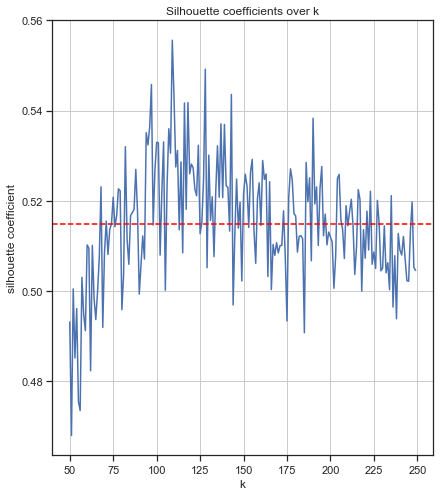

In [22]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(50, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [23]:
df_gas_mod_kmeans['labels'] = cluster_assignments

In [24]:
df_gas_mod_kmeans[0:5];

In [25]:
kmeans_ft_pca = pca.fit_transform((df_gas_mod_kmeans.iloc[:,:-1]))
df_gas_mod_kmeans['x']=kmeans_ft_pca[:,0]
df_gas_mod_kmeans['y']=kmeans_ft_pca[:,1]
df_gas_mod_kmeans['z']=kmeans_ft_pca[:,2]
pca.components_.shape

(3, 35)

In [26]:
df_gas_mod_kmeans[df_gas_mod_kmeans['labels']==17]

price base_engine_size  \
/cars/2019/dodge/journey/79183         0.032575              2.4   
/cars/2019/dodge/journey/79181         0.023304              2.4   
/cars/2019/dodge/journey/79187         0.021950              2.4   
/cars/2019/ford/explorer/78156         0.067620              2.3   
/cars/2019/ford/explorer/78157         0.063140              2.3   
/cars/2019/gmc/acadia/78309            0.046545            1.988   
/cars/2019/gmc/acadia/78312            0.034461              2.5   
/cars/2019/gmc/acadia/78313            0.042378              2.5   
/cars/2019/kia/sorento/78595           0.028190              2.4   
/cars/2019/kia/sorento/78596           0.035065              2.4   
/cars/2019/kia/sorento/78597           0.031315              2.4   
/cars/2019/mazda/cx-9/78742            0.062880              2.5   
/cars/2019/mazda/cx-9/78743            0.059129              2.5   
/cars/2019/mazda/cx-9/78744            0.068557              2.5   
/cars/2019/mazda/cx-9/78745            0.045045              2.5   
/cars/2019/mazda/cx-9/78746            0.041295              2.5   
/cars/2019/mazda/cx-9/78747            0.051400              2.5   
/cars/2019/mazda/cx-9/78748            0.047649              2.5   
/cars/2019/mercedes-benz/metris/79661  0.046545                2   
/cars/2019/mitsubishi/outlander/79697  0.028617              2.4   
/cars/2019/mitsubishi/outlander/79699  0.030075              2.4   
/cars/2019/mitsubishi/outlander/79700  0.034242              2.4   
/cars/2019/mitsubishi/outlander/79701  0.027575              2.4   
/cars/2019/mitsubishi/outlander/79702  0.031742              2.4   
/cars/2019/mitsubishi/outlander/79703  0.030492              2.4   
/cars/2019/mitsubishi/outlander/79704  0.034659              2.4   
/cars/2019/subaru/ascent/78907         0.040701              2.4   
/cars/2019/subaru/ascent/78908         0.055285              2.4   
/cars/2019/subaru/ascent/78909         0.055285              2.4   
/cars/2019/subaru/ascent/78910         0.045285              2.4   
/cars/2019/subaru/ascent/78911         0.045285              2.4   
/cars/2019/subaru/ascent/78912         0.067161              2.4   
/cars/2019/toyota/highlander/79959     0.040045              2.7   
/cars/2019/volkswagen/atlas/80052      0.038409                2   
/cars/2019/volkswagen/atlas/80038      0.045076                2   
/cars/2019/volkswagen/atlas/80039      0.048826                2   
/cars/2019/volkswagen/tiguan/80096     0.024658                2   
/cars/2019/volkswagen/tiguan/80087     0.029658                2   
/cars/2019/volkswagen/tiguan/80089     0.040284                2   
/cars/2019/volkswagen/tiguan/80095     0.044243                2   
/cars/2019/volkswagen/tiguan/80093     0.044139                2   
/cars/2019/volvo/xc90/79077            0.077589                2   
/cars/2019/volvo/xc90/79078            0.092694                2   
/cars/2019/volvo/xc90/79079            0.072380                2   
/cars/2019/volvo/xc90/79080            0.087486                2   
/cars/2019/volvo/xc90/79081            0.102695                2   
/cars/2019/volvo/xc90/79082            0.090090                2   
/cars/2019/volvo/xc90/79083            0.100403                2   
/cars/2019/volvo/xc90/79085            0.124780                2   
/cars/2019/volvo/xc90/79086            0.112175                2   
/cars/2019/volvo/xc90/79087            0.122488                2   

                                       fuel_tank_capacity  \
/cars/2019/dodge/journey/79183                   0.329268   
/cars/2019/dodge/journey/79181                   0.329268   
/cars/2019/dodge/journey/79187                   0.329268   
/cars/2019/ford/explorer/78156                   0.282927   
/cars/2019/ford/explorer/78157                   0.282927   
/cars/2019/gmc/acadia/78309                      0.365854   
/cars/2019/gmc/acadia/78312                      0.292683   
/cars/2019/gmc/ac

In [27]:
import plotly.express as px
fig = px.scatter_3d(df_gas_mod_kmeans, x='x', y='y', z='z', color='labels')
fig.show()

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



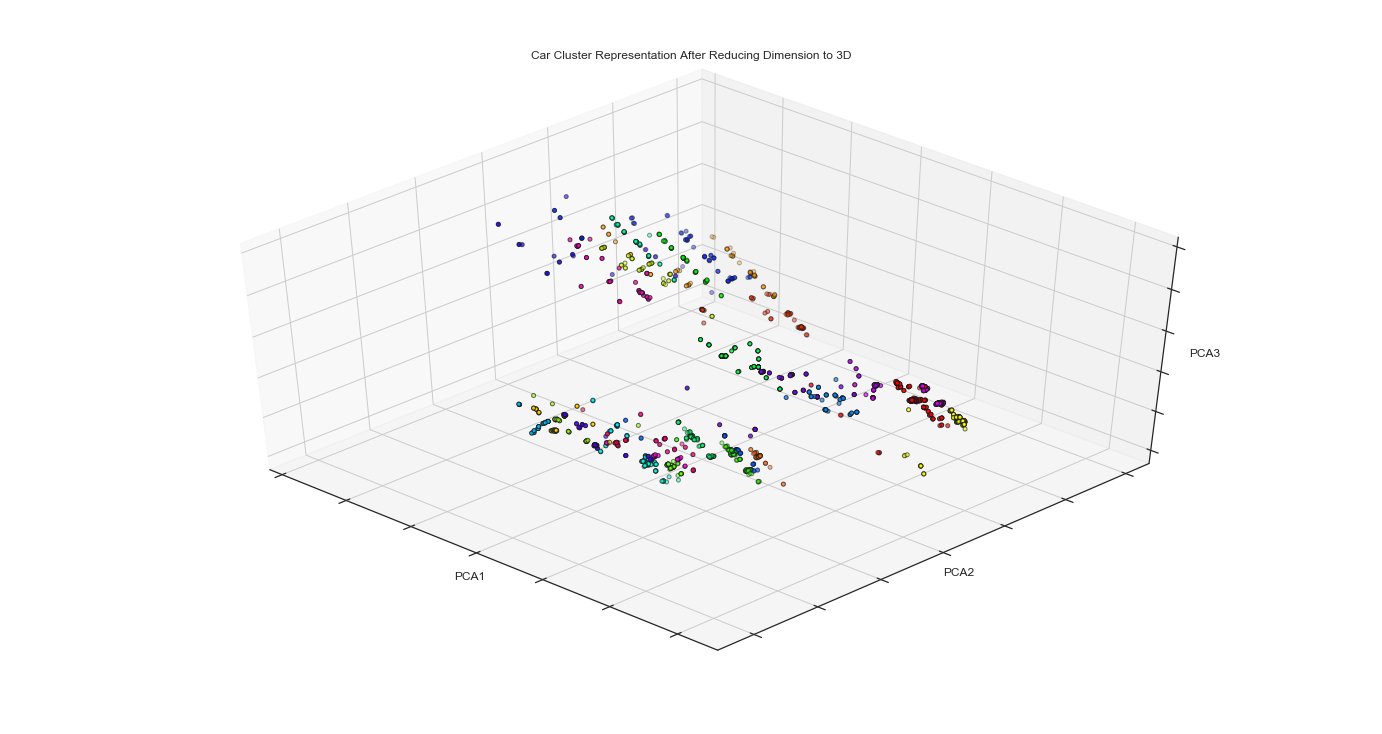

In [28]:
threed_figures(k_means, df_gas_mod_kmeans)

In [29]:
calinski_harabaz_score(df_gas_mod, labels)

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning:

Function calinski_harabaz_score is deprecated; Function 'calinski_harabaz_score' has been renamed to 'calinski_harabasz_score' and will be removed in version 0.23.



645.255899650505

## AgglomerativeClustering

### Linkage = Single

In [30]:
df_gas_hac_single = df_gas_mod.copy()

In [31]:
agg_clust_single = AgglomerativeClustering(linkage='single', affinity='cosine', n_clusters=110)
assigned_clust_single = agg_clust_single.fit_predict(df_gas_hac_single)
df_gas_hac_single['labels'] = assigned_clust_single

In [32]:
# Generate silhouette coefficient for each k
X = df_gas_hac_single.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

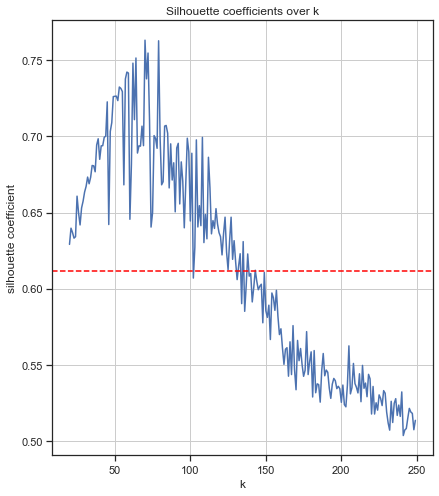

In [33]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [34]:
hac_single_ft_pca = pca.fit_transform((df_gas_hac_single.iloc[:,:-1]))
df_gas_hac_single['x']=hac_single_ft_pca[:,0]
df_gas_hac_single['y']=hac_single_ft_pca[:,1]
df_gas_hac_single['z']=hac_single_ft_pca[:,2]

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



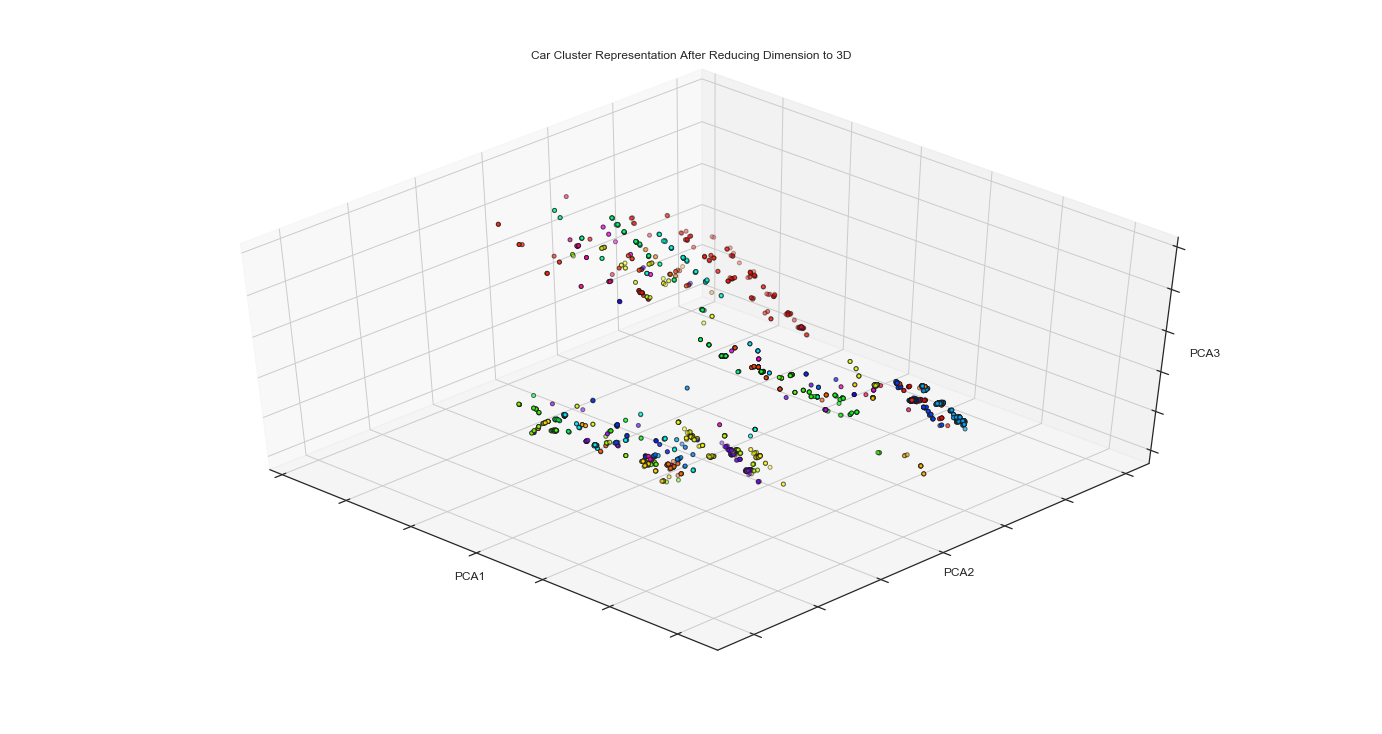

In [35]:
threed_figures(agg_clust_single, df_gas_hac_single)

### Linkage = Complete

In [36]:
df_gas_hac_complete = df_gas_mod.copy()

In [37]:
agg_clust_complete = AgglomerativeClustering(linkage='complete', affinity='cosine', n_clusters=110)
assigned_clust_complete = agg_clust_complete.fit_predict(df_gas_hac_complete)
df_gas_hac_complete['labels'] = assigned_clust_complete

In [38]:
# Generate silhouette coefficient for each k
X = df_gas_hac_complete.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

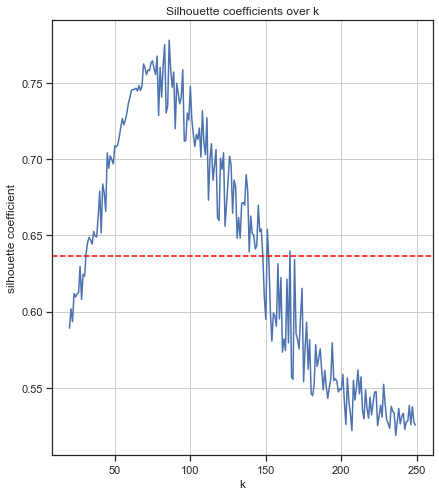

In [39]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [40]:
hac_comp_ft_pca = pca.fit_transform((df_gas_hac_complete.iloc[:,:-1]))
df_gas_hac_complete['x']=hac_comp_ft_pca[:,0]
df_gas_hac_complete['y']=hac_comp_ft_pca[:,1]
df_gas_hac_complete['z']=hac_comp_ft_pca[:,2]

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



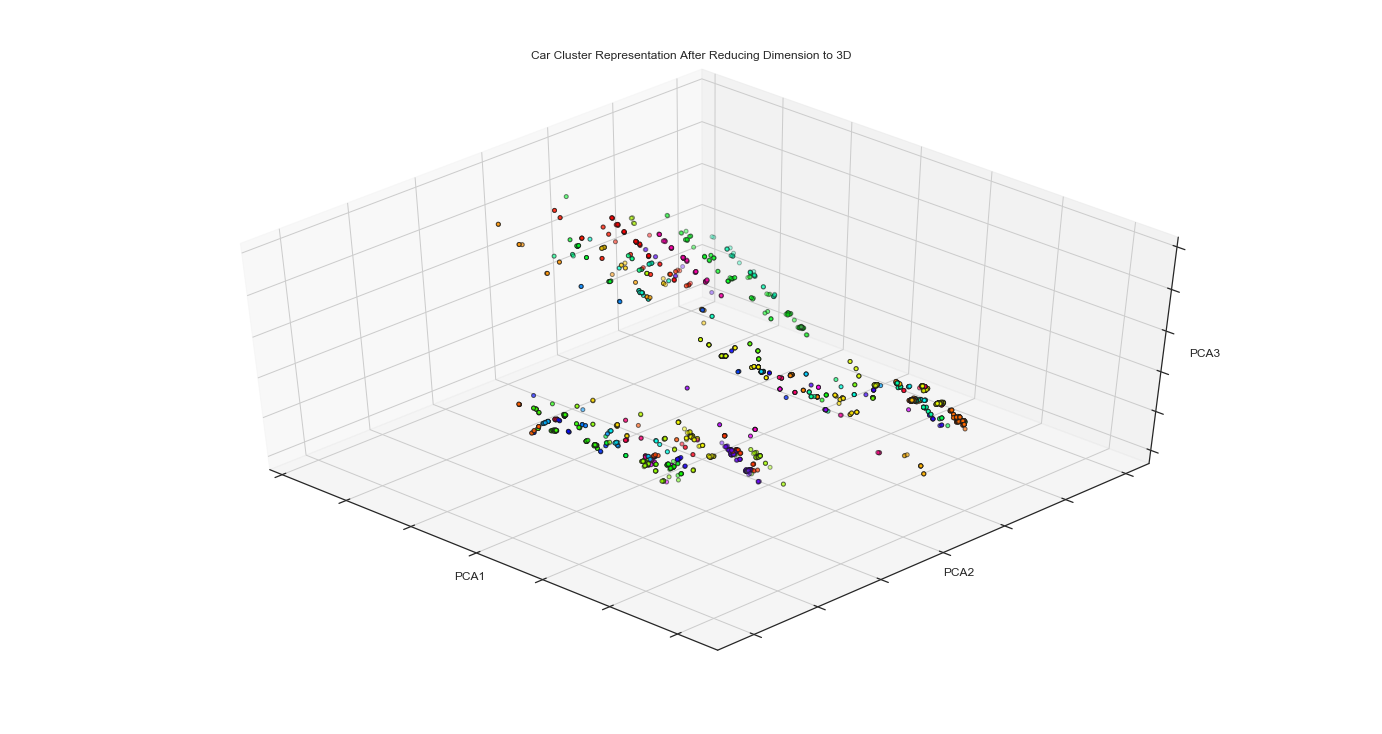

In [41]:
threed_figures(agg_clust_complete, df_gas_hac_complete)

### Linkage = Average

In [42]:
df_gas_hac_avg = df_gas_mod.copy()

In [43]:
agg_clust_avg = AgglomerativeClustering(linkage='average', affinity='cosine', n_clusters=110)
assigned_clust_avg = agg_clust_avg.fit_predict(df_gas_hac_avg)
df_gas_hac_avg['labels'] = assigned_clust_avg

In [44]:
# Generate silhouette coefficient for each k
X = df_gas_hac_avg.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = KMeans(n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

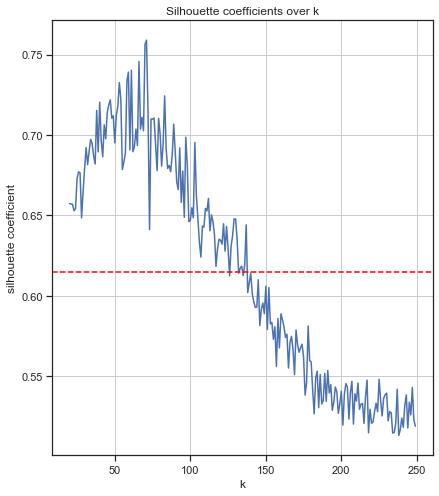

In [45]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [46]:
hac_avg_ft_pca = pca.fit_transform((df_gas_hac_avg.iloc[:,:-1]))
df_gas_hac_avg['x']=hac_avg_ft_pca[:,0]
df_gas_hac_avg['y']=hac_avg_ft_pca[:,1]
df_gas_hac_avg['z']=hac_avg_ft_pca[:,2]

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



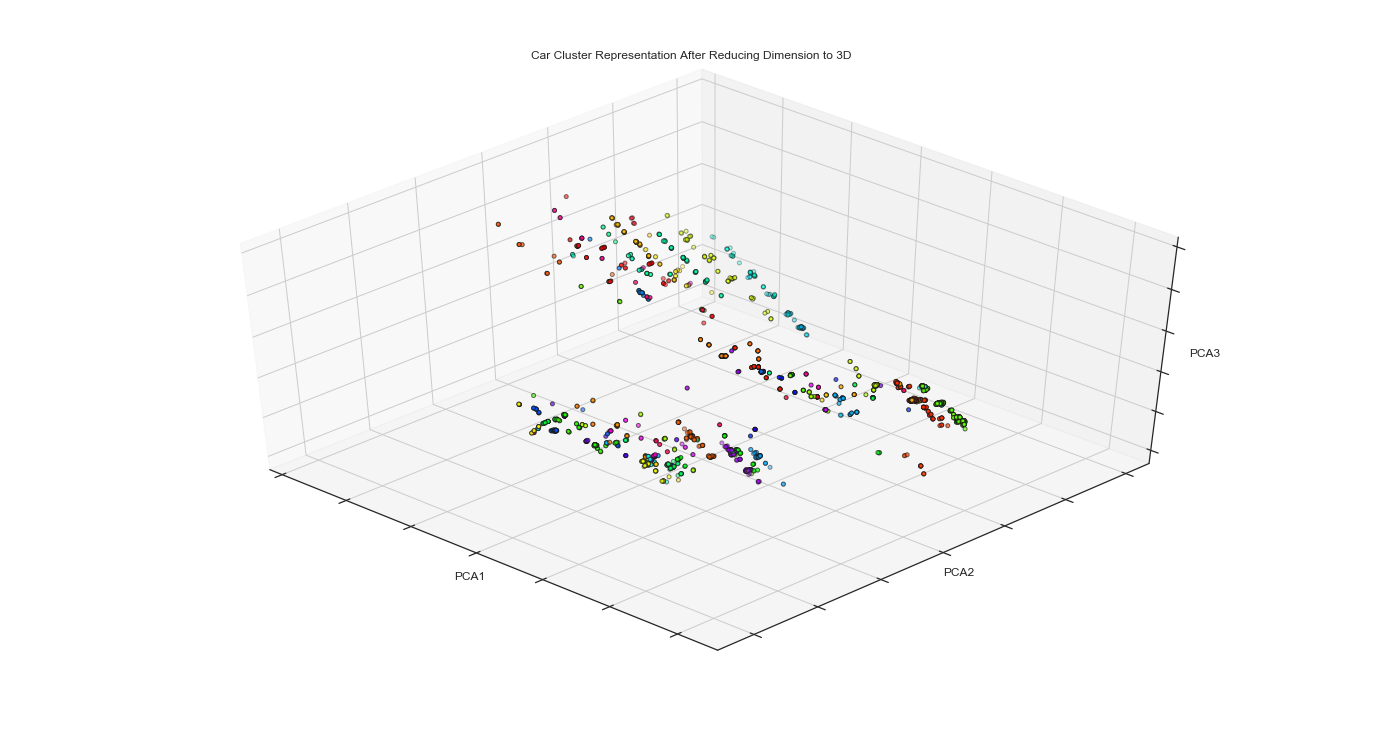

In [47]:
threed_figures(agg_clust_avg, df_gas_hac_avg)

### Linkage = Ward

In [48]:
df_gas_hac_ward = df_gas_mod.copy()

In [49]:
df_gas_hac_ward.iloc[:5,:-2];

In [50]:
agg_clust_ward = AgglomerativeClustering(linkage='ward', n_clusters=110)
assigned_clust_ward = agg_clust_ward.fit_predict(df_gas_hac_ward)
df_gas_hac_ward['labels'] = assigned_clust_ward

In [51]:
# Generate silhouette coefficient for each k
X = df_gas_hac_ward.copy()
silhouette_plot = []
for k in range(20, 250):
    clusters = AgglomerativeClustering(linkage='ward', n_clusters=k)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

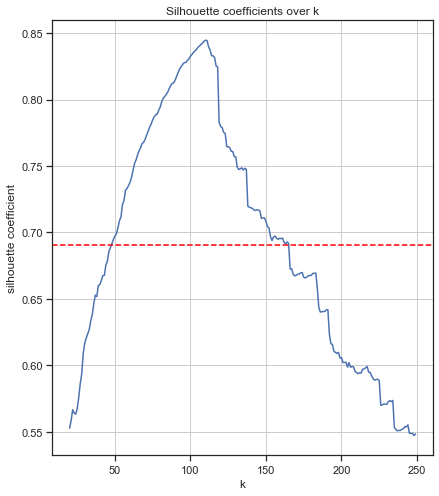

In [52]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(20, 250), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")

plt.grid(True)

In [53]:
assigned_clust_ward

array([55, 55, 55, ..., 42, 42, 42], dtype=int64)

In [54]:
hac_ward_ft_pca = pca.fit_transform((df_gas_hac_ward.iloc[:,:-1]))
df_gas_hac_ward['x']=hac_ward_ft_pca[:,0]
df_gas_hac_ward['y']=hac_ward_ft_pca[:,1]
df_gas_hac_ward['z']=hac_ward_ft_pca[:,2]

In [55]:
df_gas_hac_ward.loc['/cars/2019/cadillac/xt5/77895','labels']

24

In [56]:
df_gas_hac_ward[df_gas_hac_ward['labels'] == 24]

price base_engine_size  \
/cars/2019/acura/rlx/79094            0.088423              3.5   
/cars/2019/acura/tlx/77647            0.049462              3.5   
/cars/2019/acura/tlx/77644            0.063213              3.5   
/cars/2019/acura/tlx/77643            0.063213              3.5   
/cars/2019/acura/tlx/77645            0.065609              3.5   
/cars/2019/acura/tlx/77646            0.057588              3.5   
/cars/2019/buick/lacrosse/77826       0.067526              3.6   
/cars/2019/buick/lacrosse/77833       0.056067              3.6   
/cars/2019/cadillac/xt5/77895         0.060911              3.6   
/cars/2019/cadillac/xt5/77893         0.075078              3.6   
/cars/2019/cadillac/xt5/77894         0.086954              3.6   
/cars/2019/ford/taurus/78227          0.051775              3.5   
/cars/2019/ford/taurus/78228          0.031961              3.5   
/cars/2019/ford/taurus/78230          0.037024              3.5   
/cars/2019/honda/passport/79308       0.049899              3.5   
/cars/2019/honda/passport/79305       0.040690              3.5   
/cars/2019/honda/passport/79311       0.055879              3.5   
/cars/2019/honda/ridgeline/78466      0.036523              3.5   
/cars/2019/honda/ridgeline/78467      0.046691              3.5   
/cars/2019/honda/ridgeline/78470      0.051129              3.5   
/cars/2019/honda/ridgeline/78472      0.043607              3.5   
/cars/2019/jeep/cherokee/78557        0.049618              3.2   
/cars/2019/jeep/grand-cherokee/78590  0.044243              3.6   
/cars/2019/kia/cadenza/79485          0.065921              3.3   
/cars/2019/kia/cadenza/79484          0.043003              3.3   
/cars/2019/kia/cadenza/79486          0.053629              3.3   
/cars/2019/lexus/es/78656             0.065786              3.5   
/cars/2019/lexus/es/78657             0.061869              3.5   
/cars/2019/lexus/es/78652             0.056337              3.5   
/cars/2019/lexus/es/78658             0.063942              3.5   
/cars/2019/lexus/rx/78673             0.076589              3.5   
/cars/2019/lexus/rx/78674             0.064817              3.5   
/cars/2019/lincoln/continental/78684  0.119977              2.7   
/cars/2019/lincoln/continental/78686  0.070182              3.7   
/cars/2019/lincoln/continental/78688  0.098445              2.7   
/cars/2019/lincoln/continental/78690  0.078099              3.7   
/cars/2019/nissan/maxima/79767        0.060588              3.5   
/cars/2019/nissan/maxima/79766        0.044982              3.5   
/cars/2019/nissan/maxima/79768        0.054337              3.5   
/cars/2019/nissan/maxima/79769        0.056608              3.5   
/cars/2019/nissan/maxima/79770        0.049170              3.5   
/cars/2019/nissan/murano/79776        0.064942              3.5   
/cars/2019/nissan/murano/79775        0.039399              3.5   
/cars/2019/nissan/murano/79777        0.055983              3.5   
/cars/2019/nissan/murano/79778        0.046003              3.5   
/cars/2019/toyota/avalon/78958        0.061129              3.5   
/cars/2019/toyota/avalon/78959        0.061963              3.5   
/cars/2019/toyota/avalon/78960        0.048004              3.5   
/cars/2019/toyota/avalon/78961        0.053212              3.5   
/cars/2019/toyota/camry/78972         0.044982              3.5   
/cars/2019/toyota/camry/78974         0.046128              3.5   

                                      fuel_tank_capacity  \
/cars/2019/acura/rlx/79094                      0.280488   
/cars/2019/acura/tlx/77647                      0.248780   
/cars/2019/acura/tlx/77644                      0.248780   
/cars/2019/acura/tlx/77643                      0.248780   
/cars/2019/acura/tlx/77645                      0.248780   
/cars/2019/acura/tlx/77646                      0.248780   
/cars/2019/buick/lacrosse/77826                 0.214634   
/cars/2019/buick/lacrosse/77833                 0.214634   
/cars/2019/cadil

In [57]:
import plotly.express as px
fig = px.scatter_3d(df_gas_hac_ward, x='x', y='y', z='z', color='labels')
fig.show()

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



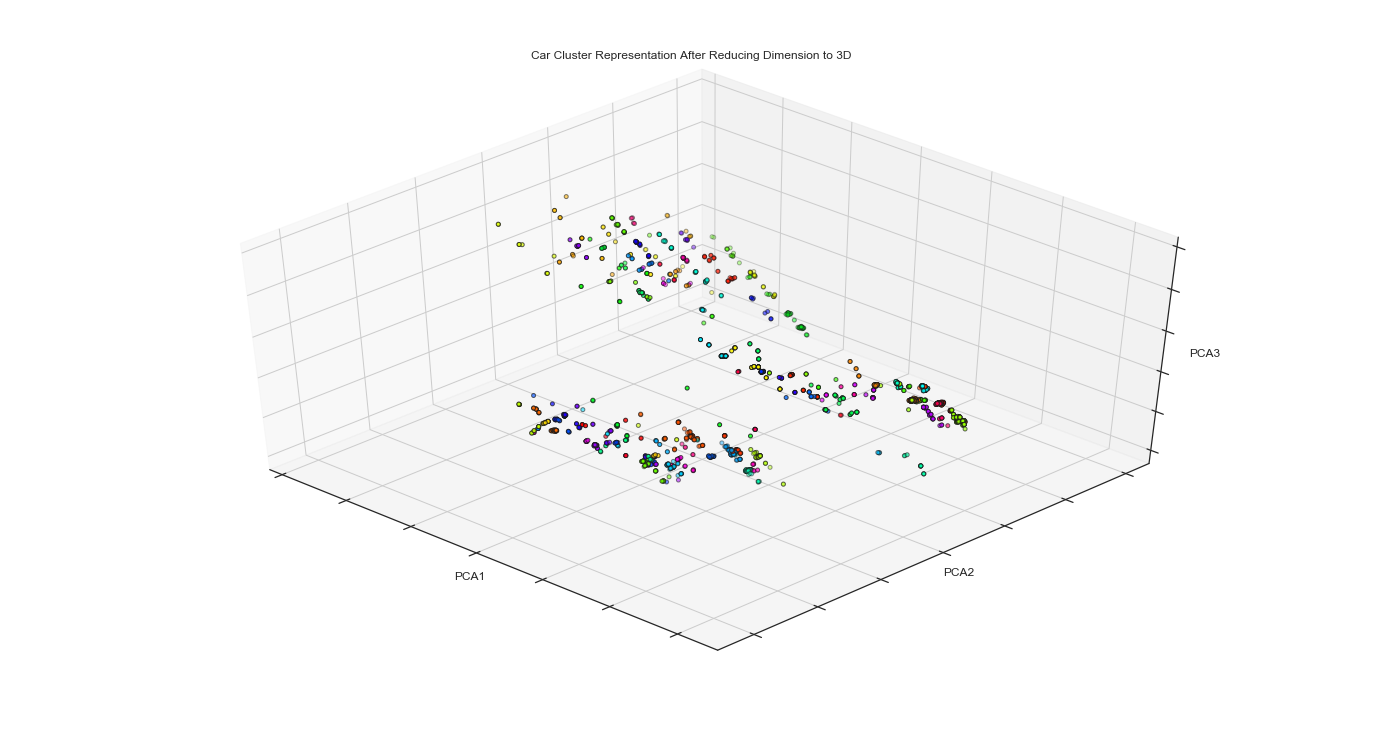

In [58]:
threed_figures(agg_clust_ward, df_gas_hac_ward)

### Dendograms, calinski_harabaz_score and silhouette_score

#### Dendograms

Text(0, 0.5, 'Cluster distance')

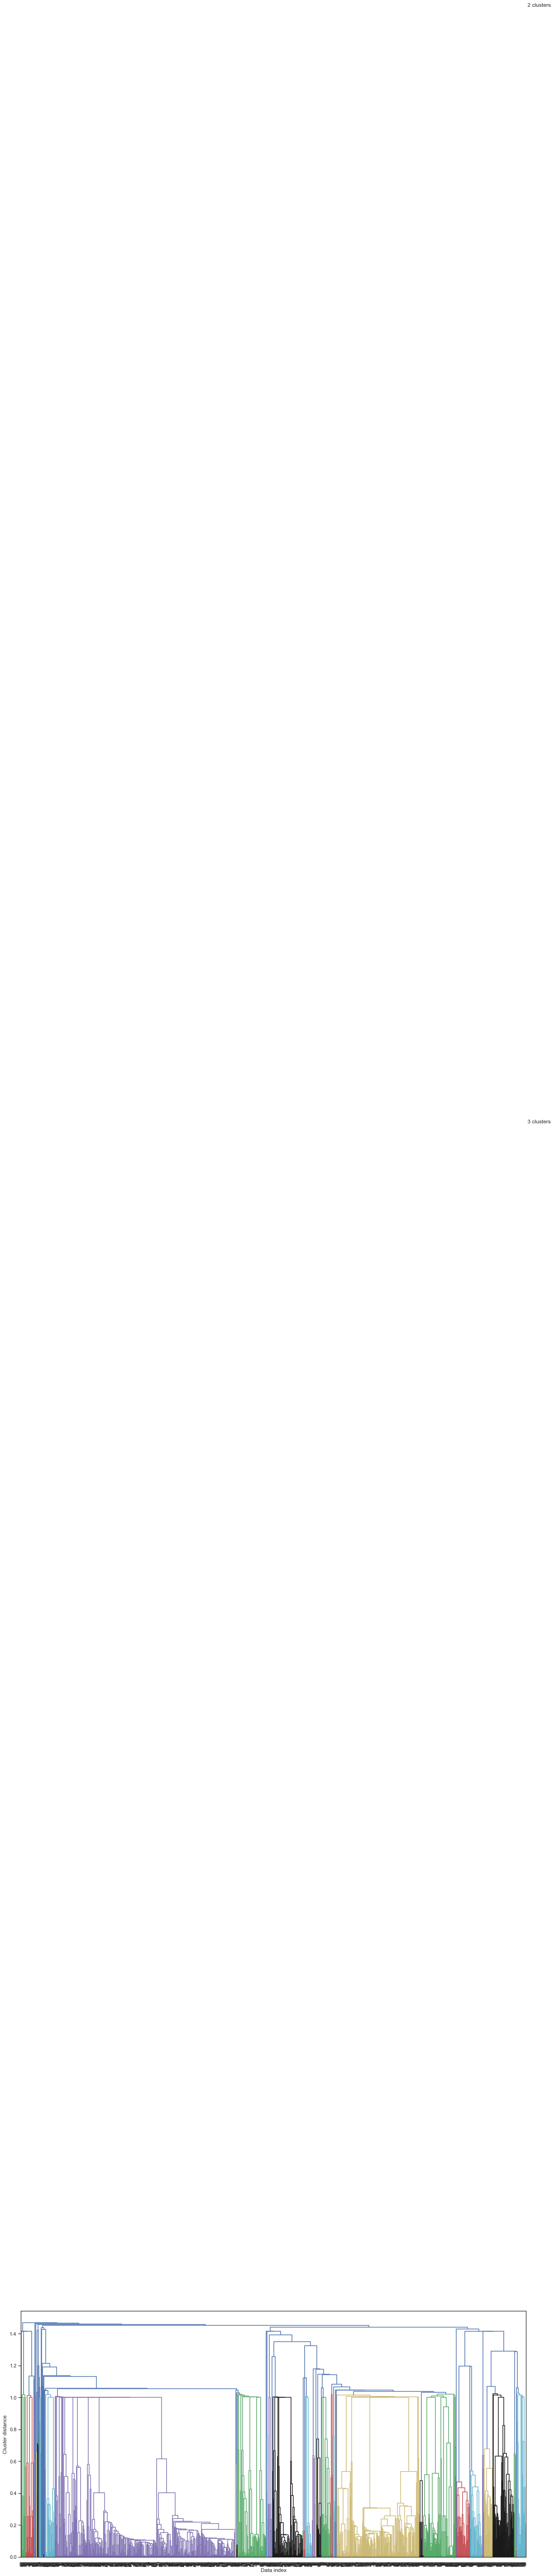

In [59]:
plt.figure(figsize=(20,10))
linkage_array = single(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

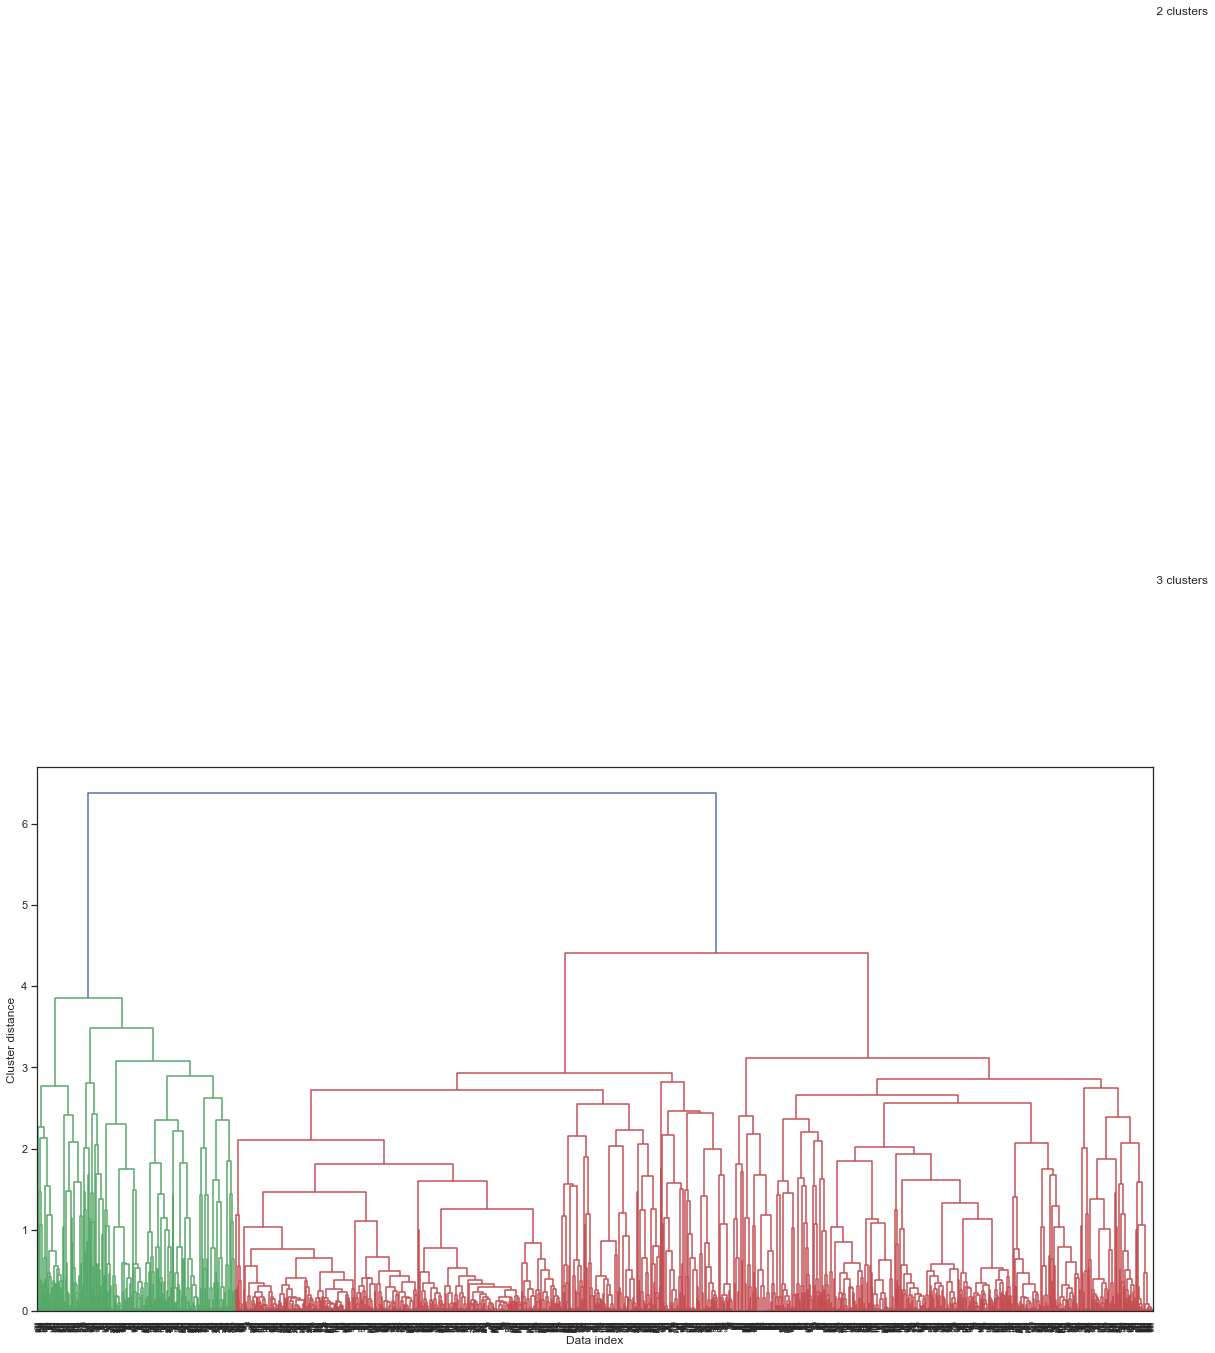

In [60]:
plt.figure(figsize=(20,10))
linkage_array = complete(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

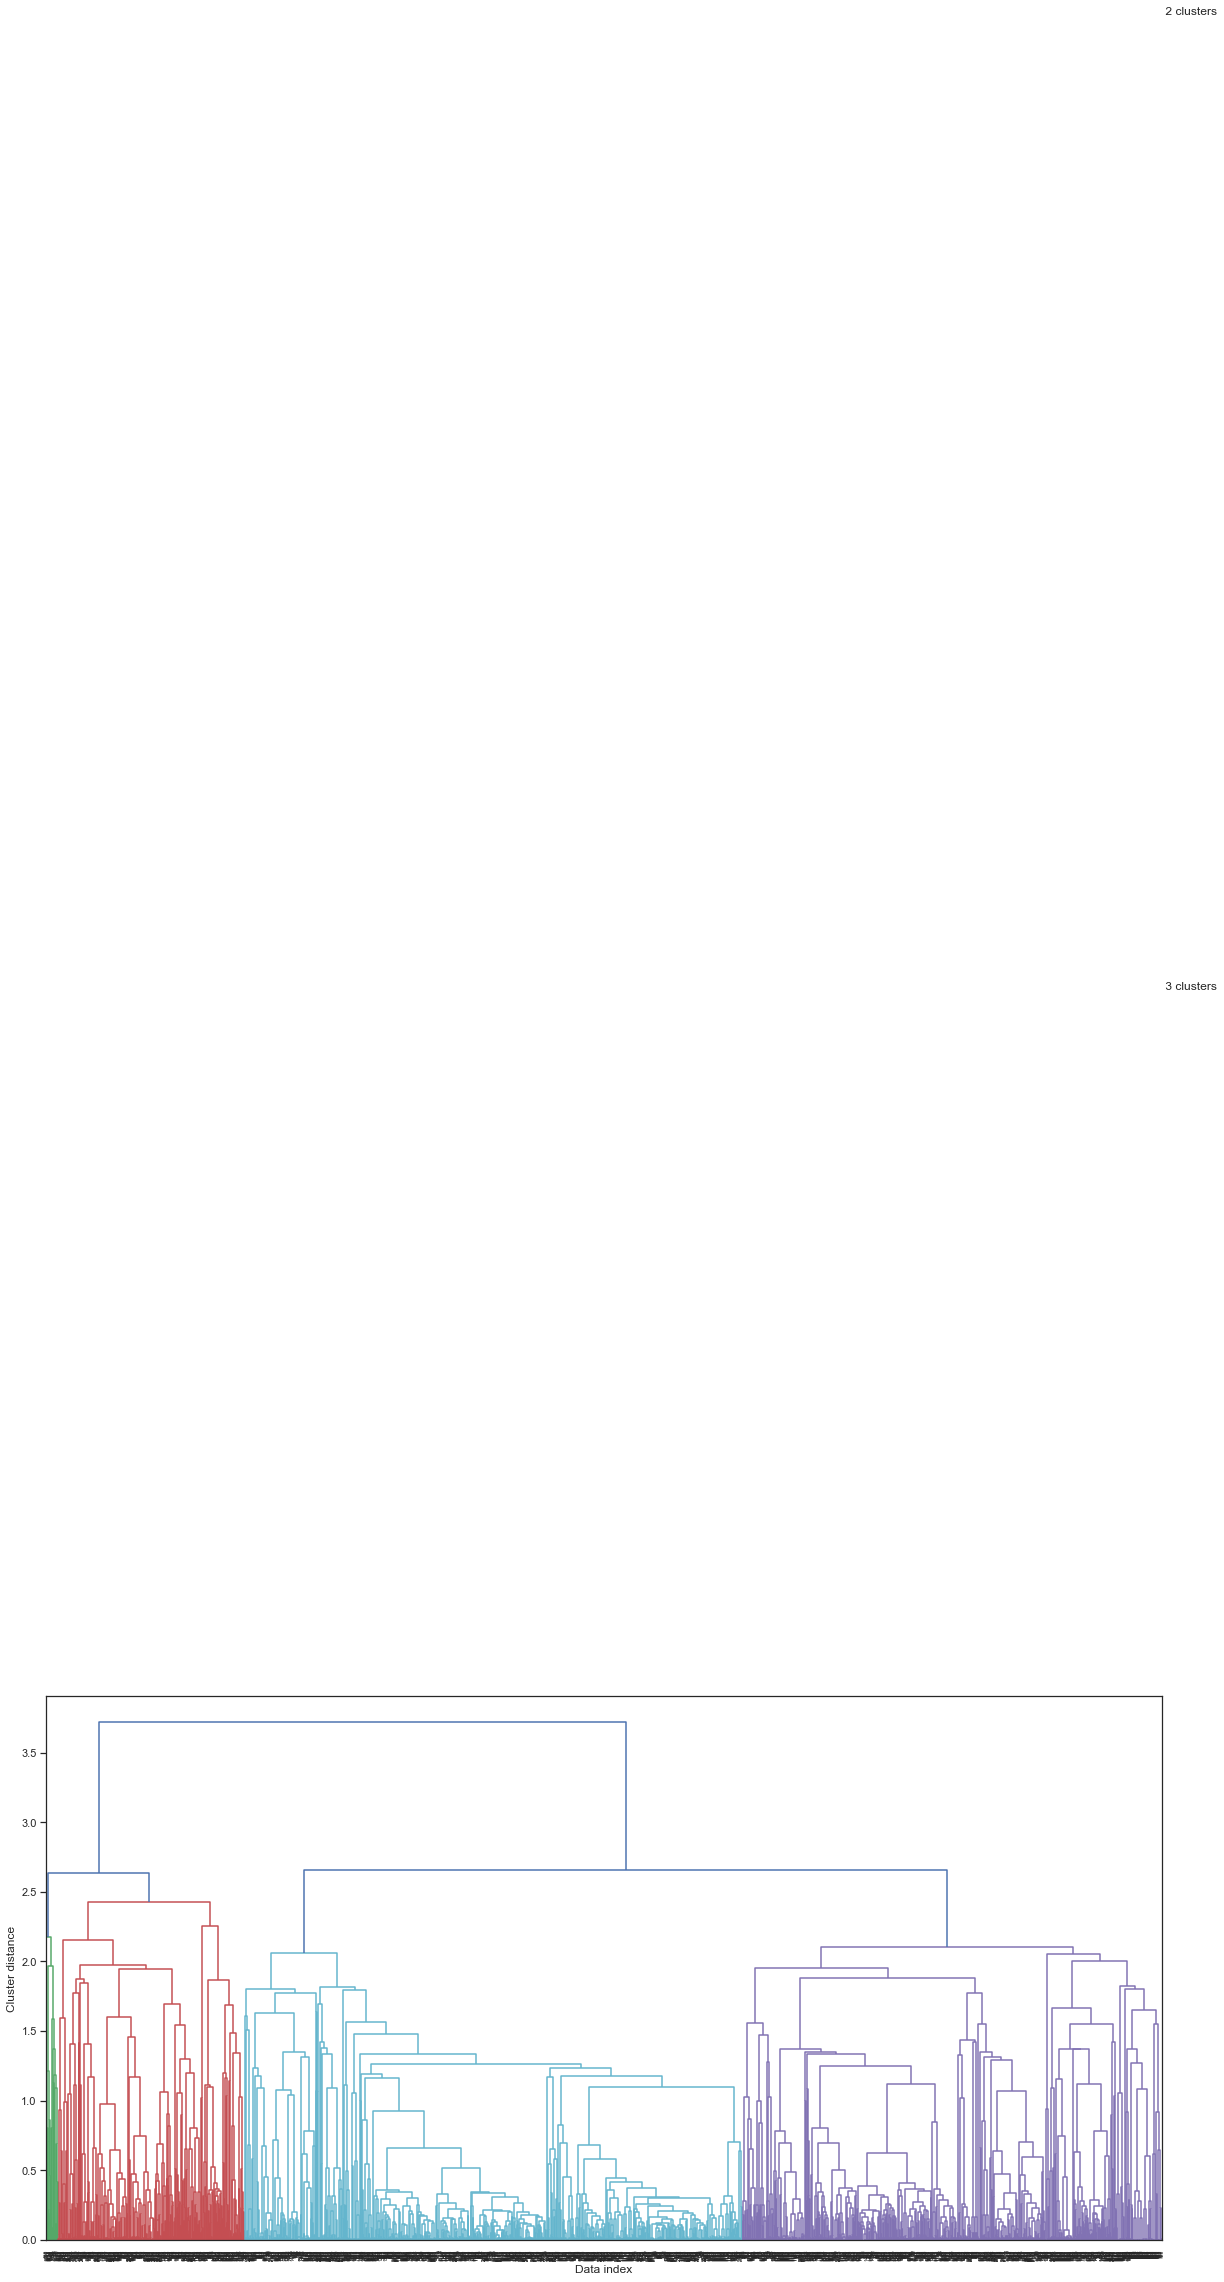

In [61]:
plt.figure(figsize=(20,10))
linkage_array = average(df_gas_mod)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 12})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

Text(0, 0.5, 'Cluster distance')

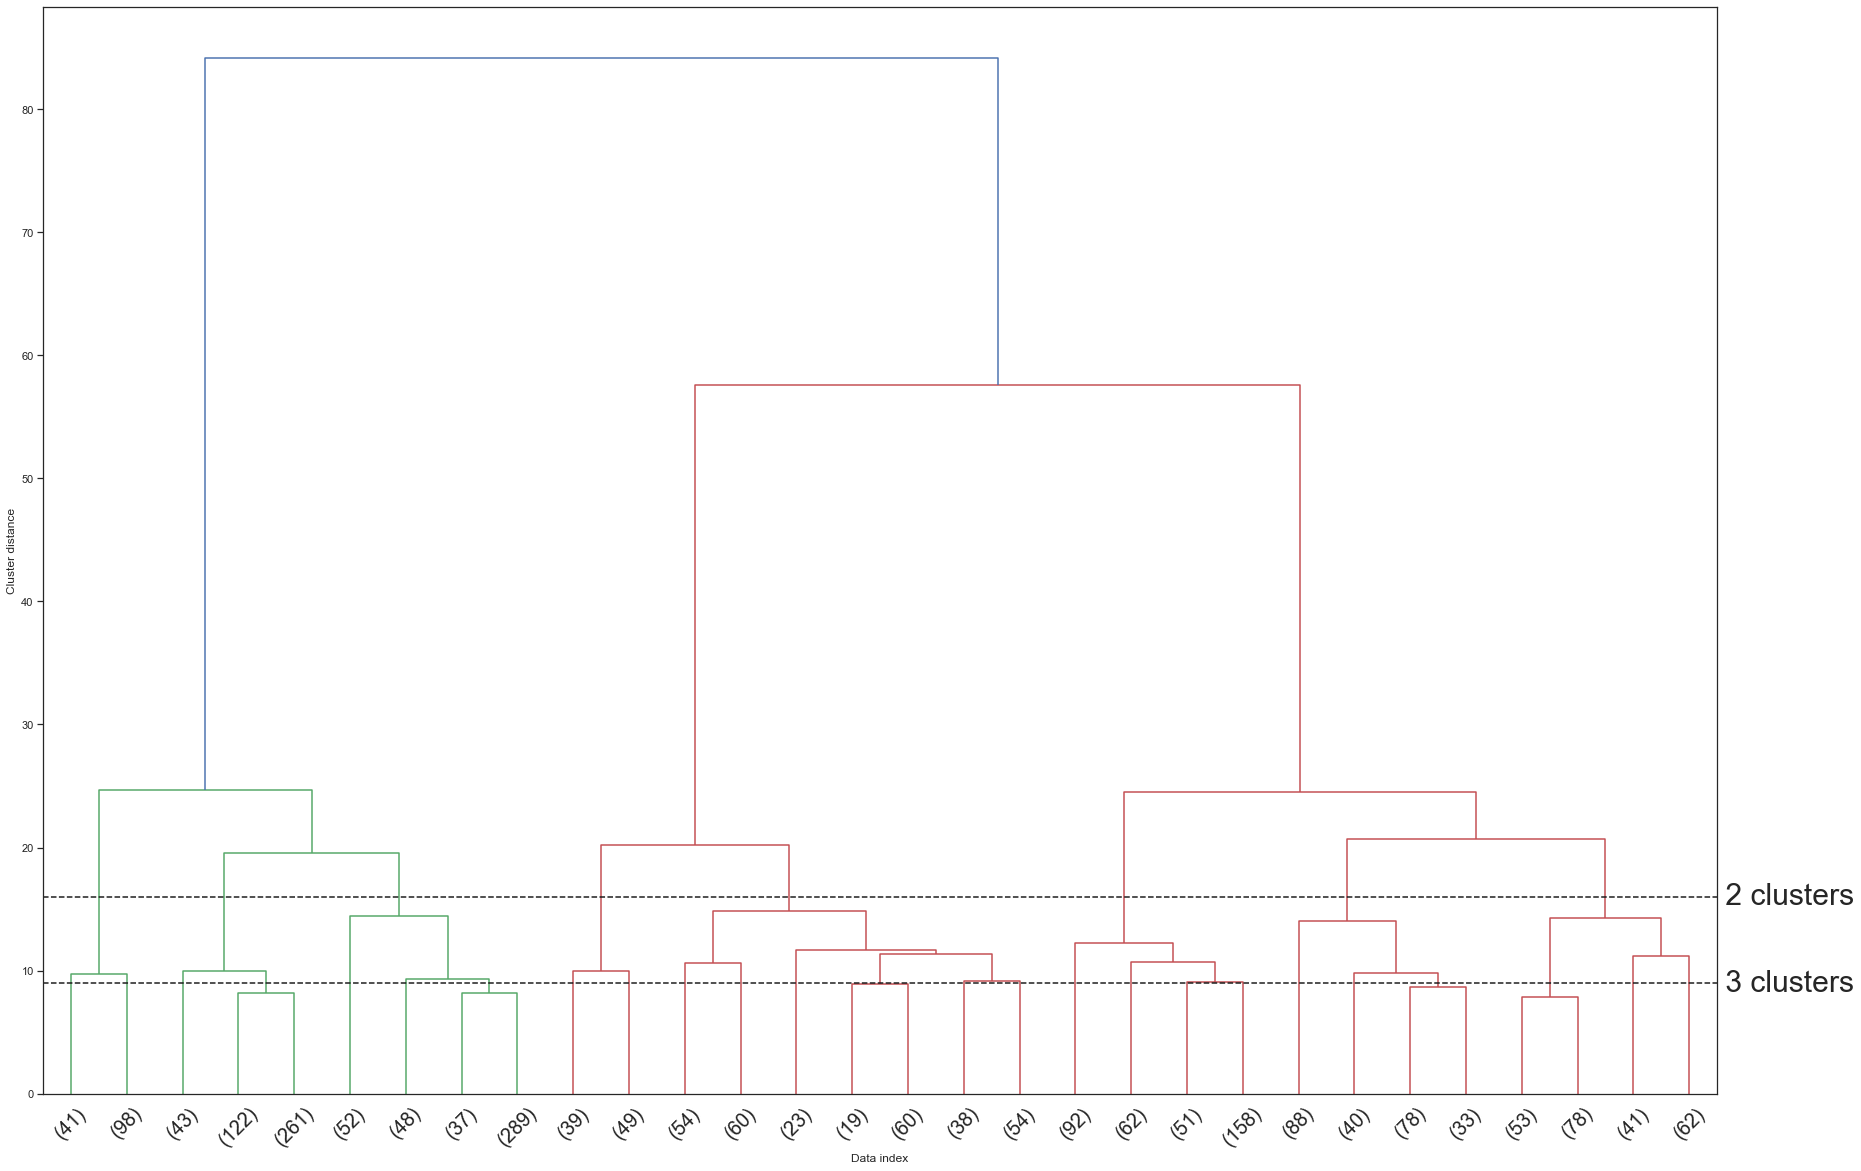

In [62]:

plt.figure(figsize=(30,20))
linkage_array = ward(df_gas_mod)

# Now we plot the dendrogram for the linkage_array containing the distances
# between clusters
dendrogram(linkage_array,leaf_font_size=20,orientation='top',
          truncate_mode = 'lastp')

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 2 clusters', va='center', fontdict={'size': 30})
ax.text(bounds[1], 9, ' 3 clusters', va='center', fontdict={'size': 30})
plt.xlabel("Data index")
plt.ylabel("Cluster distance")

In [63]:
as_kmeans = k_means.fit_predict(df_gas_mod)
as_single = agg_clust_single.fit_predict(df_gas_mod)
as_comp = agg_clust_complete.fit_predict(df_gas_mod)
as_avg = agg_clust_avg.fit_predict(df_gas_mod)
as_ward = agg_clust_ward.fit_predict(df_gas_mod)

In [64]:
labels_kmeans = labels
labels_single = agg_clust_single.labels_
labels_comp = agg_clust_complete.labels_
labels_avg = agg_clust_avg.labels_
labels_ward = agg_clust_ward.labels_

#### calinski_harabasz_score

In [65]:
metrics.calinski_harabasz_score(df_gas_mod, labels_kmeans)  

645.255899650505

In [66]:
metrics.calinski_harabasz_score(df_gas_mod,labels_single)

288.5351145641826

In [67]:
metrics.calinski_harabasz_score(df_gas_mod,labels_ward)

810.8271071906455

In [68]:
metrics.calinski_harabasz_score(df_gas_mod,labels_avg)  

428.2076357488284

In [69]:
metrics.calinski_harabasz_score(df_gas_mod,labels_comp)  

475.00389032139003

#### silhouette_score

In [70]:
metrics.silhouette_score(df_gas_mod, labels_kmeans)

0.43566151194550895

In [71]:
metrics.silhouette_score(df_gas_mod, labels_single) 

0.5440914206234837

In [72]:
metrics.silhouette_score(df_gas_mod, labels_ward) 

0.5489013298538111

In [73]:
metrics.silhouette_score(df_gas_mod,labels_avg)  

0.5774927919456233

In [74]:
metrics.silhouette_score(df_gas_mod, labels_comp)  

0.5343925354189291

Recommender

In [75]:
df_gas_hac_ward['labels'];

In [76]:
df_for_brands_gas[df_gas_hac_ward['labels']==0][['brand','model','Torque','price', 'Passenger Capacity', 'trim']]

brand     model Torque  price  \
/cars/2019/gmc/canyon/78339          GMC    Canyon    275  31000   
/cars/2019/gmc/canyon/78336          GMC    Canyon    275  36400   
/cars/2019/gmc/canyon/78337          GMC    Canyon    275  37800   
/cars/2019/gmc/canyon/78338          GMC    Canyon    275  34300   
/cars/2019/jeep/wrangler/79478      Jeep  Wrangler    260  38045   
/cars/2019/jeep/wrangler/79483      Jeep  Wrangler    260  28045   
/cars/2019/nissan/frontier/79751  Nissan  Frontier    281  33530   
/cars/2019/nissan/frontier/79752  Nissan  Frontier    281  28610   
/cars/2019/toyota/tacoma/80010    Toyota    Tacoma    265  35830   
/cars/2019/toyota/tacoma/80016    Toyota    Tacoma    265  34520   

                                 Passenger Capacity  \
/cars/2019/gmc/canyon/78339                       4   
/cars/2019/gmc/canyon/78336                       4   
/cars/2019/gmc/canyon/78337                       4   
/cars/2019/gmc/canyon/78338                       4   
/cars/2019/jeep/wrangler/79478                    4   
/cars/2019/jeep/wrangler/79483                    4   
/cars/2019/nissan/frontier/79751                  4   
/cars/2019/nissan/frontier/79752                  4   
/cars/2019/toyota/tacoma/80010                    4   
/cars/2019/toyota/tacoma/80016                    4   

                                                                      trim  
/cars/2019/gmc/canyon/78339                             4WD Ext Cab 128.3"  
/cars/2019/gmc/canyon/78336         4WD Ext Cab 128.3" All Terrain w/Cloth  
/cars/2019/gmc/canyon/78337       4WD Ext Cab 128.3" All Terrain w/Leather  
/cars/2019/gmc/canyon/78338                         4WD Ext Cab 128.3" SLE  
/cars/2019/jeep/wrangler/79478                                 Rubicon 4x4  
/cars/2019/jeep/wrangler/79483                                 Sport S 4x4  
/cars/2019/nissan/frontier/79751             King Cab 4x4 PRO-4X Automatic  
/cars/2019/nissan/frontier/79752                 King Cab 4x4 SV Automatic  
/cars/2019/toyota/tacoma/80010        TRD Off Road Access Cab 6' Bed V6 AT  
/cars/2019/toyota/tacoma/80016           TRD Sport Access Cab 6' Bed V6 MT

In [77]:
df_for_brands_gas[df_gas_mod_kmeans['labels']==0][['brand','model','Torque','price', 'Passenger Capacity', 'trim']]

brand  model Torque  price  \
/cars/2019/acura/rdx/77635          Acura    RDX    280  39300   
/cars/2019/acura/rdx/77633          Acura    RDX    280  47400   
/cars/2019/acura/rdx/77632          Acura    RDX    280  45500   
/cars/2019/acura/rdx/77634          Acura    RDX    280  42500   
/cars/2018/alfa-romeo/giulia/75371   Alfa  Romeo    306  40195   
...                                   ...    ...    ...    ...   
/cars/2019/volvo/xc60/79066         Volvo   XC60    258  41500   
/cars/2019/volvo/xc60/79067         Volvo   XC60    258  48350   
/cars/2019/volvo/xc60/79071         Volvo   XC60    295  52250   
/cars/2019/volvo/xc60/79072         Volvo   XC60    295  44900   
/cars/2019/volvo/xc60/79073         Volvo   XC60    295  51750   

                                   Passenger Capacity                  trim  
/cars/2019/acura/rdx/77635                          5                   AWD  
/cars/2019/acura/rdx/77633                          5     AWD w/Advance Pkg  
/cars/2019/acura/rdx/77632                          5      AWD w/A-Spec Pkg  
/cars/2019/acura/rdx/77634                          5  AWD w/Technology Pkg  
/cars/2018/alfa-romeo/giulia/75371                  5            Giulia AWD  
...                                               ...                   ...  
/cars/2019/volvo/xc60/79066                         5       T5 AWD Momentum  
/cars/2019/volvo/xc60/79067                         5       T5 AWD R-Design  
/cars/2019/volvo/xc60/79071                         5    T6 AWD Inscription  
/cars/2019/volvo/xc60/79072                         5       T6 AWD Momentum  
/cars/2019/volvo/xc60/79073                         5       T6 AWD R-Design  

[327 rows x 6 columns]

### PCA and AgglomerativeClustering

In [78]:
pca15 = PCA(n_components=15)
df_gas_transformed = pca15.fit_transform(df_gas_mod)

In [79]:
pca15.explained_variance_

array([2.18067477, 0.40634561, 0.29808329, 0.22366855, 0.1582216 ,
       0.1378909 , 0.10007716, 0.06925548, 0.05105436, 0.04180616,
       0.04120234, 0.03396822, 0.03146559, 0.02101526, 0.01905857])

In [80]:
pca15.explained_variance_ratio_

array([0.56176957, 0.1046798 , 0.07679005, 0.05761986, 0.0407599 ,
       0.03552245, 0.02578115, 0.01784109, 0.01315225, 0.0107698 ,
       0.01061425, 0.00875064, 0.00810594, 0.0054138 , 0.00490973])

In [81]:
np.cumsum(pca15.explained_variance_)

array([2.18067477, 2.58702038, 2.88510367, 3.10877222, 3.26699382,
       3.40488472, 3.50496187, 3.57421736, 3.62527171, 3.66707788,
       3.70828021, 3.74224843, 3.77371402, 3.79472928, 3.81378785])

In [82]:
np.cumsum(pca15.explained_variance_ratio_)

array([0.56176957, 0.66644937, 0.74323942, 0.80085929, 0.84161918,
       0.87714163, 0.90292278, 0.92076388, 0.93391613, 0.94468593,
       0.95530017, 0.96405082, 0.97215676, 0.97757056, 0.98248028])

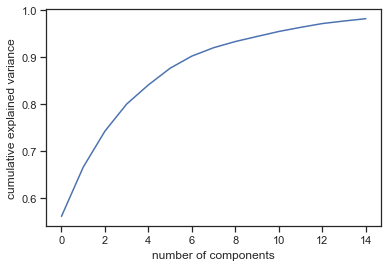

In [83]:
plt.plot(np.cumsum(pca15.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [84]:
df_gas_transformed = pd.DataFrame(df_gas_transformed, 
                                  index=df_gas_mod.index, 
                                  columns=list(map(lambda x: 'pca'+str(x), range(1,16))))
df_gas_transformed.shape

(2223, 15)

In [85]:
agg_clust_ward_pca = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_pca = agg_clust_ward_pca.fit_predict(pca15.fit_transform(df_gas_transformed))

In [86]:
df_gas_transformed['labels']=assigned_clust_ward_pca

In [87]:
df_gas_transformed.iloc[:,:-1];

In [88]:
df_gas_transformed

pca1      pca2      pca3      pca4      pca5  \
/cars/2019/acura/ilx/79088  -1.173004 -0.606646  0.043851  0.231883 -0.432325   
/cars/2019/acura/ilx/79090  -1.172719 -0.606591  0.043741  0.231782 -0.432173   
/cars/2019/acura/ilx/79089  -1.172460 -0.606539  0.043678  0.231666 -0.432055   
/cars/2019/acura/ilx/79092  -1.172615 -0.606565  0.043813  0.231671 -0.432181   
/cars/2019/acura/ilx/79091  -1.172341 -0.606510  0.043735  0.231555 -0.432050   
...                               ...       ...       ...       ...       ...   
/cars/2019/volvo/xc90/79083 -1.109578  0.173171  0.271359  0.624819  0.459096   
/cars/2019/volvo/xc90/79084 -1.140035  0.304583  0.666951  0.267595  0.606832   
/cars/2019/volvo/xc90/79085 -1.103158  0.163797  0.261741  0.618207  0.466374   
/cars/2019/volvo/xc90/79086 -1.103442  0.163723  0.261469  0.618561  0.466439   
/cars/2019/volvo/xc90/79087 -1.103210  0.163784  0.261692  0.618271  0.466386   

                                 pca6      pca7      pca8      pca9     pca10  \
/cars/2019/acura/ilx/79088  -0.210355 -0.101451  0.031667 -0.107163 -0.041398   
/cars/2019/acura/ilx/79090  -0.210330 -0.101096  0.031631 -0.106746 -0.041283   
/cars/2019/acura/ilx/79089  -0.210380 -0.100705  0.031569 -0.106367 -0.041186   
/cars/2019/acura/ilx/79092  -0.210545 -0.100755  0.031531 -0.106594 -0.041264   
/cars/2019/acura/ilx/79091  -0.210577 -0.100360  0.031474 -0.106193 -0.041159   
...                               ...       ...       ...       ...       ...   
/cars/2019/volvo/xc90/79083  0.829503  0.747979  0.038985  0.088070 -0.157861   
/cars/2019/volvo/xc90/79084  0.046969  0.305096 -0.501283  0.292776  0.394959   
/cars/2019/volvo/xc90/79085  0.811602  0.860220 -0.046422  0.237474 -0.101175   
/cars/2019/volvo/xc90/79086  0.812342  0.859142 -0.046091  0.237059 -0.101211   
/cars/2019/volvo/xc90/79087  0.811736  0.860024 -0.046362  0.237399 -0.101181   

                                pca11     pca12     pca13     pca14     pca15  \
/cars/2019/acura/ilx/79088   0.091152  0.151012 -0.015005 -0.059812  0.008951   
/cars/2019/acura/ilx/79090   0.091638  0.150462 -0.014872 -0.058385  0.008010   
/cars/2019/acura/ilx/79089   0.092077  0.150043 -0.014734 -0.056924  0.006910   
/cars/2019/acura/ilx/79092   0.091805  0.150511 -0.014772 -0.057358  0.006910   
/cars/2019/acura/ilx/79091   0.092269  0.150045 -0.014632 -0.055858  0.005816   
...                               ...       ...       ...       ...       ...   
/cars/2019/volvo/xc90/79083  0.011089 -0.090135 -0.112249  0.153336 -0.038200   
/cars/2019/volvo/xc90/79084  0.572346 -0.623913  0.722335  0.190172 -0.014771   
/cars/2019/volvo/xc90/79085  0.150200 -0.318392  0.849687  0.179832 -0.134171   
/cars/2019/volvo/xc90/79086  0.149756 -0.318700  0.849381  0.176684 -0.130650   
/cars/2019/volvo/xc90/79087  0.150120 -0.318448  0.849632  0.179260 -0.133531   

                             labels  
/cars/2019/acura/ilx/79088       10  
/cars/2019/acura/ilx/79090       10  
/cars/2019/acura/ilx/79089       10  
/cars/2019/acura/ilx/79092       10  
/cars/2019/acura/ilx/79091       10  
...                             ...  
/cars/2019/volvo/xc90/79083       9  
/cars/2019/volvo/xc90/79084       9  
/cars/2019/volvo/xc90/79085       9  
/cars/2019/volvo/xc90/79086       9  
/cars/2019/volvo/xc90/79087       9  

[2223 rows x 16 columns]

In [89]:
metrics.silhouette_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

0.4853689290054707

In [90]:
metrics.calinski_harabasz_score(df_gas_transformed.iloc[:,:-1], agg_clust_ward_pca.labels_) 

730.2450403955186

In [91]:
df_for_brands_gas[df_gas_transformed['labels']==2][['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

brand   model Torque  \
/cars/2018/alfa-romeo/4c/75370           Alfa   Romeo    258   
/cars/2018/alfa-romeo/4c-spider/69017    Alfa   Romeo    258   
/cars/2019/audi/a3/79106                 Audi      A3    258   
/cars/2019/audi/a3/79104                 Audi      A3    258   
/cars/2019/audi/a3/79108                 Audi      A3    258   
...                                       ...     ...    ...   
/cars/2019/toyota/86/78952             Toyota      86    156   
/cars/2019/toyota/86/78953             Toyota      86    156   
/cars/2019/toyota/86/78954             Toyota      86    156   
/cars/2019/toyota/tacoma/80000         Toyota  Tacoma    180   
/cars/2019/toyota/tacoma/80005         Toyota  Tacoma    180   

                                      Passenger Capacity  price  \
/cars/2018/alfa-romeo/4c/75370                         2  55900   
/cars/2018/alfa-romeo/4c-spider/69017                  2  65900   
/cars/2019/audi/a3/79106                               4  41700   
/cars/2019/audi/a3/79104                               4  41700   
/cars/2019/audi/a3/79108                               4  41700   
...                                                  ...    ...   
/cars/2019/toyota/86/78952                             4  28585   
/cars/2019/toyota/86/78953                             4  26455   
/cars/2019/toyota/86/78954                             4  32420   
/cars/2019/toyota/tacoma/80000                         4  25850   
/cars/2019/toyota/tacoma/80005                         4  27625   

                                                               trim  
/cars/2018/alfa-romeo/4c/75370                             4C Coupe  
/cars/2018/alfa-romeo/4c-spider/69017              4C Spider Spider  
/cars/2019/audi/a3/79106                    Premium 45 TFSI quattro  
/cars/2019/audi/a3/79104               Premium Plus 45 TFSI quattro  
/cars/2019/audi/a3/79108                   Prestige 45 TFSI quattro  
...                                                             ...  
/cars/2019/toyota/86/78952                                GT Manual  
/cars/2019/toyota/86/78953                                   Manual  
/cars/2019/toyota/86/78954                            TRD SE Manual  
/cars/2019/toyota/tacoma/80000           SR Access Cab 6' Bed I4 AT  
/cars/2019/toyota/tacoma/80005          SR5 Access Cab 6' Bed I4 AT  

[101 rows x 6 columns]

In [92]:
transformed_plot=df_gas_transformed.copy()

In [93]:
pca_plot = pca.fit_transform((transformed_plot.iloc[:,:-1]))

In [94]:
transformed_plot['x']=pca_plot[:,0]

In [95]:
transformed_plot['y']=pca_plot[:,1]

In [96]:
transformed_plot['z']=pca_plot[:,2]

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:43: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



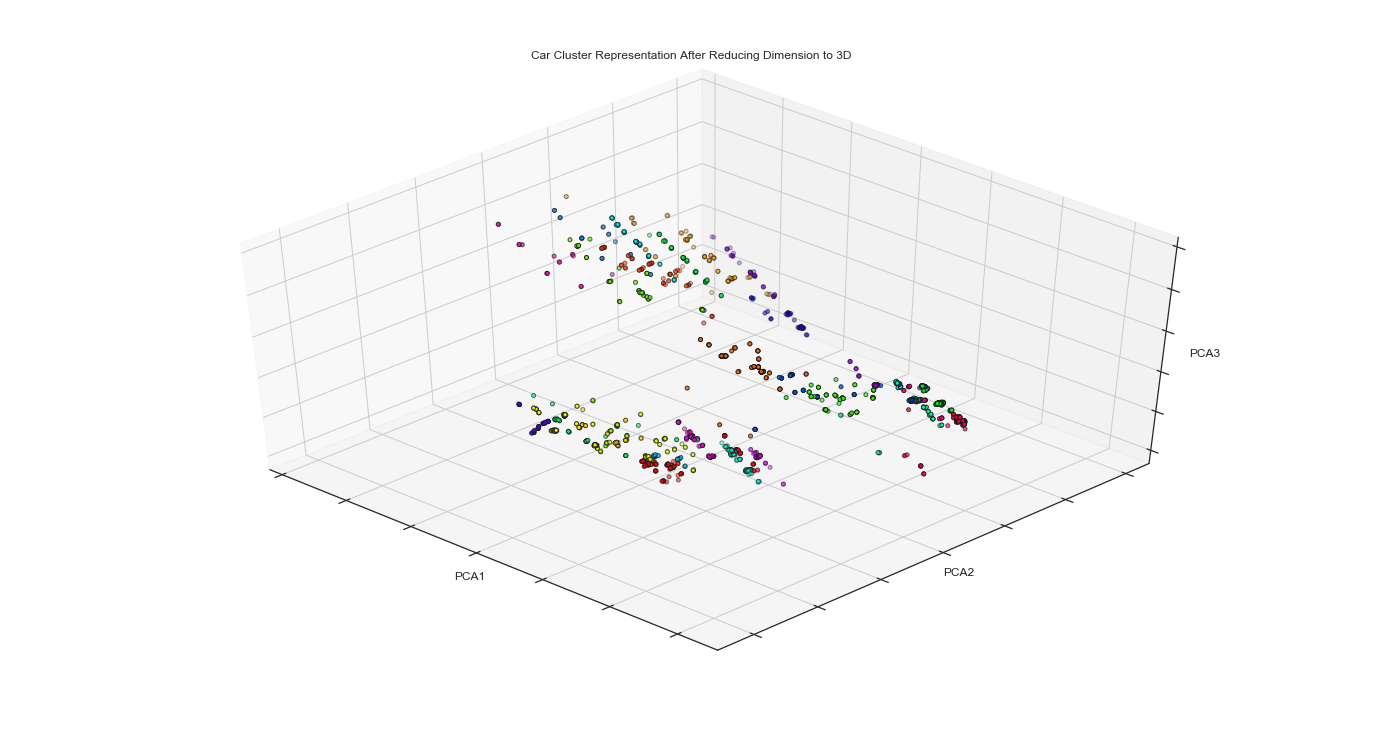

In [97]:
threed_figures(agg_clust_ward_pca, transformed_plot)

## Annoy

### TruncatedSVD

In [98]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=11)

In [99]:
df_Annoy_svd = svd.fit_transform(df_gas_mod)

In [100]:
print(np.cumsum(svd.explained_variance_ratio_))
print(svd.singular_values_)

[0.40968461 0.61621028 0.69876376 0.75899439 0.81644876 0.85216069
 0.88574629 0.91152626 0.92917066 0.94224498 0.95301177]
[176.12175421  43.79096137  26.74633793  22.98941737  22.26836021
  17.55782886  17.08826438  14.91179647  12.33754308  10.61952387
   9.63676808]


In [101]:
df_Annoy_svd.shape

(2223, 11)

In [102]:
from annoy import AnnoyIndex

f = df_Annoy_svd.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_svd.shape[0]):
    v = df_Annoy_svd[i]
    t.add_item(i, v)

t.build(15)
t.save('annoy_svd.ann')

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.



True

In [103]:
df_gas_mod

price base_engine_size  fuel_tank_capacity  \
/cars/2019/acura/ilx/79088   0.028002              2.4            0.151220   
/cars/2019/acura/ilx/79090   0.031648              2.4            0.151220   
/cars/2019/acura/ilx/79089   0.035815              2.4            0.151220   
/cars/2019/acura/ilx/79092   0.035607              2.4            0.151220   
/cars/2019/acura/ilx/79091   0.039774              2.4            0.151220   
...                               ...              ...                 ...   
/cars/2019/volvo/xc90/79083  0.100403                2            0.287805   
/cars/2019/volvo/xc90/79084  0.192597                2            0.151220   
/cars/2019/volvo/xc90/79085  0.124780                2            0.151220   
/cars/2019/volvo/xc90/79086  0.112175                2            0.151220   
/cars/2019/volvo/xc90/79087  0.122488                2            0.151220   

                             epa_mileage_combined  Horsepower    Torque  \
/cars/2019/acura/ilx/79088               0.168675    0.171071  0.123113   
/cars/2019/acura/ilx/79090               0.168675    0.171071  0.123113   
/cars/2019/acura/ilx/79089               0.168675    0.171071  0.123113   
/cars/2019/acura/ilx/79092               0.168675    0.171071  0.123113   
/cars/2019/acura/ilx/79091               0.168675    0.171071  0.123113   
...                                           ...         ...       ...   
/cars/2019/volvo/xc90/79083              0.096386    0.331015  0.256678   
/cars/2019/volvo/xc90/79084              0.132530    0.447844  0.462253   
/cars/2019/volvo/xc90/79085              0.132530    0.447844  0.462253   
/cars/2019/volvo/xc90/79086              0.132530    0.447844  0.462253   
/cars/2019/volvo/xc90/79087              0.132530    0.447844  0.462253   

                             third_row_seating  first_row_seating  \
/cars/2019/acura/ilx/79088            0.000000           0.156915   
/cars/2019/acura/ilx/79090            0.000000           0.156915   
/cars/2019/acura/ilx/79089            0.000000           0.156915   
/cars/2019/acura/ilx/79092            0.000000           0.156915   
/cars/2019/acura/ilx/79091            0.000000           0.156915   
...                                        ...                ...   
/cars/2019/volvo/xc90/79083           0.349219           0.189329   
/cars/2019/volvo/xc90/79084           0.000000           0.189329   
/cars/2019/volvo/xc90/79085           0.349219           0.189329   
/cars/2019/volvo/xc90/79086           0.349219           0.189329   
/cars/2019/volvo/xc90/79087           0.349219           0.189329   

                             rear_row_seating  curb_weight  ...  \
/cars/2019/acura/ilx/79088           0.189442     0.156797  ...   
/cars/2019/acura/ilx/79090           0.189442     0.160939  ...   
/cars/2019/acura/ilx/79089           0.189442     0.164314  ...   
/cars/2019/acura/ilx/79092           0.189442     0.161246  ...   
/cars/2019/acura/ilx/79091           0.189442     0.164928  ...   
...                                       ...          ...  ...   
/cars/2019/volvo/xc90/79083          0.322913     0.356091  ...   
/cars/2019/volvo/xc90/79084          0.363062     0.505216  ...   
/cars/2019/volvo/xc90/79085          0.322913     0.459497  ...   
/cars/2019/volvo/xc90/79086          0.322913     0.459497  ...   
/cars/2019/volvo/xc90/79087          0.322913     0.459497  ...   

                             Cylinders_4.0  Cylinders_5.0  Cylinders_6.0  \
/cars/2019/acura/ilx/79088               1              0              0   
/cars/2019/acura/ilx/79090               1              0              0   
/cars/2019/acura/ilx/79089               1              0              0   
/cars/2019/acura/ilx/79092               1              0              0   
/cars/2019/acura/ilx/79091               1              0              0   
...                                    ...            ...            ...   
/cars/2019/volvo/xc90/79083 

In [104]:
df_gas_mod.index[100]

'/cars/2019/audi/a5/79114'

In [105]:
def nearest_car_Annoy(df, car_idx, index, n, print_output=True):
    nn = index.get_nns_by_item(car_idx, n)
    if print_output == True:
        print('Closest to %s : \n' % df.index[car_idx])
    cars = [df.index[i] for i in nn]
    if print_output == True:
        return df_for_brands_gas.loc[cars, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [106]:
def index_finder(string1,string2):
    index_list = []
    for i in df_for_brands_gas.index:
        if re.findall(str(string1).lower()+'\/'+str(string2).lower(), i):
            index_list.append(i)
    return df_for_brands_gas.loc[index_list, ['brand','model','Torque','Passenger Capacity', 'price', 'trim']]

In [107]:
nearest_car_Annoy(df_gas_mod, 100, t, n=20)

Closest to /cars/2019/audi/a5/79114 : 



brand     model Torque  \
/cars/2019/audi/a5/79114                         Audi        A5    369   
/cars/2019/audi/a5/79113                         Audi        A5    369   
/cars/2019/audi/a5/79115                         Audi        A5    369   
/cars/2019/mercedes-benz/c-class/78753  Mercedes-Benz         C    384   
/cars/2019/audi/s5-cabriolet/77732               Audi        S5    369   
/cars/2019/audi/s5-cabriolet/77733               Audi        S5    369   
/cars/2019/mercedes-benz/c-class/78754  Mercedes-Benz         C    384   
/cars/2017/infiniti/q60-coupe/47451          Infiniti       Q60    350   
/cars/2019/audi/s5-coupe/77735                   Audi        S5    369   
/cars/2019/audi/s5-coupe/77734                   Audi        S5    369   
/cars/2019/audi/s5-coupe/77736                   Audi        S5    369   
/cars/2019/bmw/4-series/77764                     BMW  4-Series    330   
/cars/2019/bmw/4-series/77763                     BMW  4-Series    330   
/cars/2019/bmw/2-series/77750                     BMW  2-Series    369   
/cars/2017/infiniti/q60-coupe/47447          Infiniti       Q60    295   
/cars/2017/infiniti/q60-coupe/47449          Infiniti       Q60    295   
/cars/2019/porsche/911/79853                  Porsche       911    331   
/cars/2019/porsche/911/79866                  Porsche       911    331   
/cars/2019/porsche/911/79852                  Porsche       911    331   
/cars/2019/audi/a5/79112                         Audi        A5    443   

                                       Passenger Capacity   price  \
/cars/2019/audi/a5/79114                                4   52400   
/cars/2019/audi/a5/79113                                4   65100   
/cars/2019/audi/a5/79115                                4   65100   
/cars/2019/mercedes-benz/c-class/78753                  4   63650   
/cars/2019/audi/s5-cabriolet/77732                      4   35100   
/cars/2019/audi/s5-cabriolet/77733                      4   35100   
/cars/2019/mercedes-benz/c-class/78754                  4   57450   
/cars/2017/infiniti/q60-coupe/47451                     4   48700   
/cars/2019/audi/s5-coupe/77735                          4   35100   
/cars/2019/audi/s5-coupe/77734                          4   35100   
/cars/2019/audi/s5-coupe/77736                          4   35100   
/cars/2019/bmw/4-series/77764                           4   53200   
/cars/2019/bmw/4-series/77763                           4   62000   
/cars/2019/bmw/2-series/77750                           4   47800   
/cars/2017/infiniti/q60-coupe/47447                     4   39070   
/cars/2017/infiniti/q60-coupe/47449                     4   39070   
/cars/2019/porsche/911/79853                            4   98000   
/cars/2019/porsche/911/79866                            4  110300   
/cars/2019/porsche/911/79852                            4  110300   
/cars/2019/audi/a5/79112                                4   74200   

                                                                                     trim  
/cars/2019/audi/a5/79114                                         Premium 3.0 TFSI quattro  
/cars/2019/audi/a5/79113                                    Premium Plus 3.0 TFSI quattro  
/cars/2019/audi/a5/79115                                        Prestige 3.0 TFSI quattro  
/cars/2019/mercedes-benz/c-class/78753                    Class AMG C 43 4MATIC Cabriolet  
/cars/2019/audi/s5-cabriolet/77732                        Cabriolet 3.0 TFSI Premium Plus  
/cars/2019/audi/s5-cabriolet/77733                            Cabriolet 3.0 TFSI Prestige  
/cars/2019/mercedes-benz/c-class/78754                        Class AMG C 43 4MATIC Coupe  
/cars/2017/infiniti/q60-coupe/47451     Coupe Red Sport 400 - Coupe 3.0L V6 Twin-turbo...  
/cars/2019/audi/s5-coupe/77735                                     Coupe 3.0 TFSI Premium  
/cars/2019/audi/s5-coupe/77734                                Coupe 3.0 TFSI Premium Plus  
/cars/2019/audi/s5-coupe/77736 

In [108]:
nearest_car_Annoy(df_gas_mod, 1295, t, n=20)

Closest to /cars/2019/lexus/ls/79559 : 



brand     model Torque Passenger Capacity  \
/cars/2019/lexus/ls/79559           Lexus        LS    442                  5   
/cars/2019/lexus/ls/79560           Lexus        LS    442                  5   
/cars/2019/ford/taurus/78231         Ford    Taurus    350                  5   
/cars/2019/cadillac/ct6/77856    Cadillac       CT6    400                  5   
/cars/2019/ford/taurus/78226         Ford    Taurus    254                  5   
/cars/2019/ford/taurus/78229         Ford    Taurus    254                  5   
/cars/2019/cadillac/xt5/77890    Cadillac       XT5    271                  5   
/cars/2019/cadillac/xt5/77891    Cadillac       XT5    271                  5   
/cars/2019/cadillac/xt5/77889    Cadillac       XT5    271                  5   
/cars/2019/cadillac/xt5/77892    Cadillac       XT5    271                  5   
/cars/2019/dodge/charger/78092      Dodge   Charger    264                  5   
/cars/2019/chrysler/300/78063    Chrysler       300    264                  5   
/cars/2019/chrysler/300/78065    Chrysler       300    260                  5   
/cars/2019/chrysler/300/78067    Chrysler       300    260                  5   
/cars/2019/chrysler/300/78068    Chrysler       300    260                  5   
/cars/2019/cadillac/cts/77861    Cadillac       CTS    285                  5   
/cars/2019/nissan/murano/79771     Nissan    Murano    240                  5   
/cars/2019/lexus/rx/78672           Lexus        RX    267                  5   
/cars/2019/buick/lacrosse/77825     Buick  Lacrosse    268                  5   
/cars/2019/lexus/rx/78671           Lexus        RX    267                  5   

                                 price                                trim  
/cars/2019/lexus/ls/79559        78670                          LS 500 AWD  
/cars/2019/lexus/ls/79560        84670                  LS 500 F SPORT AWD  
/cars/2019/ford/taurus/78231     42975                             SHO AWD  
/cars/2019/cadillac/ct6/77856    78195        4-Door Sedan 3.6L Luxury AWD  
/cars/2019/ford/taurus/78226     39160                         Limited AWD  
/cars/2019/ford/taurus/78229     32080                             SEL AWD  
/cars/2019/cadillac/xt5/77890    65895                 AWD 4-Door Platinum  
/cars/2019/cadillac/xt5/77891    56695           AWD 4-Door Premium Luxury  
/cars/2019/cadillac/xt5/77889    50995                   AWD 4-Door Luxury  
/cars/2019/cadillac/xt5/77892    44695                          AWD 4-Door  
/cars/2019/dodge/charger/78092   32995                             SXT AWD  
/cars/2019/chrysler/300/78063    38895                            300S AWD  
/cars/2019/chrysler/300/78065    40145                         Limited AWD  
/cars/2019/chrysler/300/78067    31495                         Touring AWD  
/cars/2019/chrysler/300/78068    31495                       Touring L AWD  
/cars/2019/cadillac/cts/77861    62195  4-Door Sedan 2.0L Turbo Luxury AWD  
/cars/2019/nissan/murano/79771   45230                        AWD Platinum  
/cars/2019/lexus/rx/78672        50620                  RX 350 F Sport AWD  
/cars/2019/buick/lacrosse/77825  47070             4-Door Sedan Avenir AWD  
/cars/2019/lexus/rx/78671        44970                          RX 350 AWD

In [109]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=3).fit_transform(df_gas_mod)

In [110]:
df_plot = pd.DataFrame(X_embedded, index=df_gas_mod.index, columns = ['x','y','z'])

In [111]:
agg_clust_ward_tsne = AgglomerativeClustering(linkage='ward', n_clusters=30)
assigned_clust_ward_tsne = agg_clust_ward_tsne.fit_predict(df_plot)

In [112]:
df_plot['labels']=assigned_clust_ward_tsne

In [113]:
import plotly.express as px
fig = px.scatter_3d(df_plot, x='x', y='y', z='z', color='labels')
fig.show()

### All Features

In [114]:
df_gas_mod.shape

(2223, 35)

In [115]:
from annoy import AnnoyIndex
import random

f = df_gas_mod.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_gas_mod.shape[0]):
    v = df_gas_mod.iloc[i,:]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.



True

In [116]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

Closest to /cars/2019/audi/a4-allroad/77690 : 



brand     model Torque  \
/cars/2019/bmw/3-series/77752           BMW  3-Series    295   
/cars/2019/audi/a5-sportback/77699     Audi        A5    273   
/cars/2019/audi/a5-sportback/77698     Audi        A5    273   
/cars/2019/audi/a5-sportback/77700     Audi        A5    273   
/cars/2019/buick/regal/79161          Buick     Regal    295   
/cars/2019/kia/stinger/79516            Kia   Stinger    260   
/cars/2019/kia/stinger/79508            Kia   Stinger    260   
/cars/2019/bmw/x2/79151                 BMW        X2    258   
/cars/2019/buick/regal/79164          Buick     Regal    295   
/cars/2019/buick/regal/79165          Buick     Regal    295   
/cars/2019/buick/regal/79163          Buick     Regal    295   
/cars/2019/bmw/4-series/77759           BMW  4-Series    258   
/cars/2019/buick/regal-tourx/77842    Buick     Regal    295   
/cars/2018/alfa-romeo/giulia/75373     Alfa     Romeo    306   
/cars/2018/alfa-romeo/giulia/75375     Alfa     Romeo    306   
/cars/2018/alfa-romeo/giulia/75371     Alfa     Romeo    306   
/cars/2019/lincoln/mkz/78706        Lincoln       MKZ    275   
/cars/2019/lincoln/mkz/78708        Lincoln       MKZ    275   
/cars/2019/audi/q3/79124               Audi        Q3    258   
/cars/2019/audi/q3/79120               Audi        Q3    258   

                                   Passenger Capacity  price  \
/cars/2019/bmw/3-series/77752                       5  42250   
/cars/2019/audi/a5-sportback/77699                  5  38995   
/cars/2019/audi/a5-sportback/77698                  5  38995   
/cars/2019/audi/a5-sportback/77700                  5  38995   
/cars/2019/buick/regal/79161                        5  31770   
/cars/2019/kia/stinger/79516                        5  41390   
/cars/2019/kia/stinger/79508                        5  35190   
/cars/2019/bmw/x2/79151                             5  38400   
/cars/2019/buick/regal/79164                        5  35070   
/cars/2019/buick/regal/79165                        5  32670   
/cars/2019/buick/regal/79163                        5  29070   
/cars/2019/bmw/4-series/77759                       5  46600   
/cars/2019/buick/regal-tourx/77842                  5  29070   
/cars/2018/alfa-romeo/giulia/75373                  5  42195   
/cars/2018/alfa-romeo/giulia/75375                  5  42195   
/cars/2018/alfa-romeo/giulia/75371                  5  40195   
/cars/2019/lincoln/mkz/78706                        5  40995   
/cars/2019/lincoln/mkz/78708                        5  46995   
/cars/2019/audi/q3/79124                            5  34700   
/cars/2019/audi/q3/79120                            5  34700   

                                                                 trim  
/cars/2019/bmw/3-series/77752                330i xDrive Sports Wagon  
/cars/2019/audi/a5-sportback/77699         Sportback 2.0 TFSI Premium  
/cars/2019/audi/a5-sportback/77698    Sportback 2.0 TFSI Premium Plus  
/cars/2019/audi/a5-sportback/77700        Sportback 2.0 TFSI Prestige  
/cars/2019/buick/regal/79161            4-Door Sedan Preferred II AWD  
/cars/2019/kia/stinger/79516                              Premium AWD  
/cars/2019/kia/stinger/79508                                 Base AWD  
/cars/2019/bmw/x2/79151             xDrive28i Sports Activity Vehicle  
/cars/2019/buick/regal/79164                 5-Door Wagon Essence AWD  
/cars/2019/buick/regal/79165               5-Door Wagon Preferred AWD  
/cars/2019/buick/regal/79163                         5-Door Wagon AWD  
/cars/2019/bmw/4-series/77759                  430i xDrive Gran Coupe  
/cars/2019/buick/regal-tourx/77842             TourX 5-Door Wagon AWD  
/cars/2018/alfa-romeo/giulia/75373                      Giulia Ti AWD  
/cars/2018/alfa-romeo/giulia/75375                Giulia Ti Sport AWD  
/cars/2018/alfa-romeo/giulia/75371                         Giulia AWD  
/cars/2019/lincoln/mkz/78706                            Reserve I AWD  
/cars/2019/lincoln/mkz/78708                        

### All Features

In [117]:
df_Annoy_pca = pca15.fit_transform(df_gas_mod)

In [118]:
from annoy import AnnoyIndex
import random

f = df_Annoy_pca.shape[1] # Length of item vector that will be indexed
t = AnnoyIndex(f)  
for i in range(df_Annoy_pca.shape[0]):
    v = df_Annoy_pca[i]
    t.add_item(i, v)

t.build(15) # 10 trees
t.save('test.ann')

c:\users\omarq\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning:

The default argument for metric will be removed in future version of Annoy. Please pass metric='angular' explicitly.



True

In [119]:
nearest_car_Annoy(df_gas_mod, 90, t, n=20)

Closest to /cars/2019/audi/a4-allroad/77690 : 



brand     model Torque  \
/cars/2019/audi/a4-allroad/77690          Audi        A4    273   
/cars/2019/audi/a4-allroad/77689          Audi        A4    273   
/cars/2019/audi/a4-allroad/77691          Audi        A4    273   
/cars/2019/genesis/g70/79255           Genesis       G70    260   
/cars/2019/bmw/3-series/77752              BMW  3-Series    295   
/cars/2019/audi/a5-sportback/77699        Audi        A5    273   
/cars/2019/audi/a5-sportback/77698        Audi        A5    273   
/cars/2019/audi/a5-sportback/77700        Audi        A5    273   
/cars/2019/kia/stinger/79508               Kia   Stinger    260   
/cars/2019/kia/stinger/79516               Kia   Stinger    260   
/cars/2019/audi/q3/79121                  Audi        Q3    258   
/cars/2019/audi/q3/79122                  Audi        Q3    258   
/cars/2019/audi/q3/79123                  Audi        Q3    258   
/cars/2019/audi/q3/79124                  Audi        Q3    258   
/cars/2019/audi/q3/79120                  Audi        Q3    258   
/cars/2019/volkswagen/arteon/80023  Volkswagen    Arteon    258   
/cars/2019/volkswagen/arteon/80026  Volkswagen    Arteon    258   
/cars/2019/kia/sportage/78611              Kia  Sportage    260   
/cars/2019/volkswagen/arteon/80025  Volkswagen    Arteon    258   
/cars/2019/volvo/xc40/70083              Volvo      XC40    258   

                                   Passenger Capacity  price  \
/cars/2019/audi/a4-allroad/77690                    5  38995   
/cars/2019/audi/a4-allroad/77689                    5  38995   
/cars/2019/audi/a4-allroad/77691                    5  38995   
/cars/2019/genesis/g70/79255                        5  36900   
/cars/2019/bmw/3-series/77752                       5  42250   
/cars/2019/audi/a5-sportback/77699                  5  38995   
/cars/2019/audi/a5-sportback/77698                  5  38995   
/cars/2019/audi/a5-sportback/77700                  5  38995   
/cars/2019/kia/stinger/79508                        5  35190   
/cars/2019/kia/stinger/79516                        5  41390   
/cars/2019/audi/q3/79121                            5  36000   
/cars/2019/audi/q3/79122                            5  36000   
/cars/2019/audi/q3/79123                            5  36000   
/cars/2019/audi/q3/79124                            5  34700   
/cars/2019/audi/q3/79120                            5  34700   
/cars/2019/volkswagen/arteon/80023                  5  37645   
/cars/2019/volkswagen/arteon/80026                  5  38910   
/cars/2019/kia/sportage/78611                       5  34600   
/cars/2019/volkswagen/arteon/80025                  5  39410   
/cars/2019/volvo/xc40/70083                         5  37700   

                                                                        trim  
/cars/2019/audi/a4-allroad/77690                    allroad 2.0 TFSI Premium  
/cars/2019/audi/a4-allroad/77689               allroad 2.0 TFSI Premium Plus  
/cars/2019/audi/a4-allroad/77691                   allroad 2.0 TFSI Prestige  
/cars/2019/genesis/g70/79255                               2.0T Advanced AWD  
/cars/2019/bmw/3-series/77752                       330i xDrive Sports Wagon  
/cars/2019/audi/a5-sportback/77699                Sportback 2.0 TFSI Premium  
/cars/2019/audi/a5-sportback/77698           Sportback 2.0 TFSI Premium Plus  
/cars/2019/audi/a5-sportback/77700               Sportback 2.0 TFSI Prestige  
/cars/2019/kia/stinger/79508                                        Base AWD  
/cars/2019/kia/stinger/79516                                     Premium AWD  
/cars/2019/audi/q3/79121            2.0 TFSI S line Premium Plus quattro AWD  
/cars/2019/audi/q3/79122                 2.0 TFSI S line Premium quattro AWD  
/cars/2019/audi/q3/79123                2.0 TFSI S line Prestige quattro AWD  
/cars/2019/audi/q3/79124                   2.0 TFSI Premium Plus quattro AWD  
/cars/2019/audi/q3/79120                        2.0 TFSI Premium quattro AWD  
/cars/2019/volkswagen/ar

# Function tobe Dashed

In [122]:
val1 = input("Enter your favourite car brand: ") 
val2 = input("And model: ")
index_finder(val1,val2)

Enter your favourite car brand: bmw
And model: 3-series


brand     model Torque Passenger Capacity  \
/cars/2019/bmw/3-series/79140   BMW  3-Series    295                  5   
/cars/2019/bmw/3-series/79139   BMW  3-Series    295                  5   
/cars/2019/bmw/3-series/77751   BMW  3-Series    258                  5   
/cars/2019/bmw/3-series/77752   BMW  3-Series    295                  5   
/cars/2019/bmw/3-series/77753   BMW  3-Series    330                  5   

                               price                      trim  
/cars/2019/bmw/3-series/79140  40250                330i Sedan  
/cars/2019/bmw/3-series/79139  40250  330i Sedan North America  
/cars/2019/bmw/3-series/77751  45400  330i xDrive Gran Turismo  
/cars/2019/bmw/3-series/77752  42250  330i xDrive Sports Wagon  
/cars/2019/bmw/3-series/77753  51250  340i xDrive Gran Turismo

In [125]:
val3 = input("Enter desired trim index: ") 
val3_iloc = list(df_gas_mod.index).index(str(val3))
nearest_car_Annoy(df_gas_mod, val3_iloc, t, n=20)

Enter desired trim index: 330i xDrive Gran Turismo


KeyboardInterrupt: 